# This is basically a simplified version of ronin_resnet in the main file

## In this file we define the train and test using the resnet model which allows us to understand the code better.

Required packages
1. data global speed
2. Data utils
3. Math utils
4. Metrics
5. resnet_model
6. transformations
7. utils

After successfully simplifying the code, we will try to make the training and evaluation work on the OXIOD dataset or the IDOL dataset
Finally, we will do transfer learning based on our own use case.

In [37]:
#import dependencies

import os
import time
from os import path as osp

import numpy as np
import torch
import json

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader

from data_glob_speed import *
from transformations import *
from metric import compute_ate_rte
from model_resnet1d import *

In [49]:
import argparse
args = argparse.Namespace()

# Hardcoded values for each argument
args.train_list = "/home/jovyan/ronin/lists/list_train-Copy1.txt"
args.mode = "train"
args.val_list = "/home/jovyan/ronin/lists/list_val-Copy2.txt"
args.test_list = "/home/jovyan/ronin/lists/list_test_seen.txt"
#dataset folder
args.root_dir = "/home/jovyan/localisation_datasets/Ronin_datasets/seen_subjects_test_set"
args.out_dir = "/home/jovyan/ronin/output"


args.test_path = None
args.cache_path = None
args.model_path = "/home/jovyan/ronin/PreTrained_Models/ronin_resnet/ronin_resnet/checkpoint_gsn_latest.pt"

args.dataset = "ronin"
args.max_ori_error = 20.0
args.step_size = 10
args.window_size = 100
args.lr = 1e-04
args.batch_size = 128
args.epochs = 3
args.arch = "resnet18"
args.cpu = False
args.run_ekf = False
args.fast_test = False
args.show_plot = True
args.continue_from = None
args.feature_sigma = 0.00001
args.target_sigma = 0.00001

np.set_printoptions(formatter={'all': lambda x: '{:.6f}'.format(x)})

In [39]:
_input_channel, _output_channel = 6, 2
_fc_config = {'fc_dim': 512, 'in_dim': 7, 'dropout': 0.5, 'trans_planes': 128}
network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [2, 2, 2, 2],
                           base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)

In [40]:
def run_test(network, data_loader, device, eval_mode=True):
    targets_all = []
    preds_all = []
    if eval_mode:
        network.eval()
    for bid, (feat, targ, _, _) in enumerate(data_loader):
        print(f'Feature shape: {feat.shape}')
        print(f'Target shape: {targ.shape}')
        pred = network(feat.to(device)).cpu().detach().numpy()
        targets_all.append(targ.detach().numpy())
        preds_all.append(pred)
    targets_all = np.concatenate(targets_all, axis=0)
    preds_all = np.concatenate(preds_all, axis=0)
    return targets_all, preds_all

In [41]:
def add_summary(writer, loss, step, mode):
    names = '{0}_loss/loss_x,{0}_loss/loss_y,{0}_loss/loss_z,{0}_loss/loss_sin,{0}_loss/loss_cos'.format(
        mode).split(',')

    for i in range(loss.shape[0]):
        writer.add_scalar(names[i], loss[i], step)
    writer.add_scalar('{}_loss/avg'.format(mode), np.mean(loss), step)

In [42]:
def get_dataset(root_dir, data_list, args, **kwargs):
    mode = kwargs.get('mode', 'train')

    random_shift, shuffle, transforms, grv_only = 0, False, None, False
    if mode == 'train':
        random_shift = args.step_size // 2
        shuffle = True
        transforms = RandomHoriRotate(math.pi * 2)
    elif mode == 'val':
        shuffle = True
    elif mode == 'test':
        shuffle = False
        grv_only = True

    if args.dataset == 'ronin':
        seq_type = GlobSpeedSequence
    dataset = StridedSequenceDataset(
        seq_type, root_dir, data_list, random_shift=random_shift, transform=transforms,
        shuffle=shuffle, grv_only=grv_only)

    global _input_channel, _output_channel
    _input_channel, _output_channel = dataset.feature_dim, dataset.target_dim
    return dataset

def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list, args, **kwargs)


In [43]:
def train(args, **kwargs):
    # Loading data
    start_t = time.time()
    train_dataset = get_dataset_from_list(args.root_dir, args.train_list, args, mode='train')
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    end_t = time.time()
    print('Training set loaded. Feature size: {}, target size: {}. Time usage: {:.3f}s'.format(
        train_dataset.feature_dim, train_dataset.target_dim, end_t - start_t))
    
    val_dataset, val_loader = None, None
    if args.val_list is not None:
        val_dataset = get_dataset_from_list(args.root_dir, args.val_list, args, mode='val')
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)
    device = torch.device('cuda:0' if torch.cuda.is_available() and not args.cpu else 'cpu')

    summary_writer = None
    
    if args.out_dir is not None:
        if not osp.isdir(args.out_dir):
            os.makedirs(args.out_dir)
        write_config(args)
        
        if not osp.isdir(osp.join(args.out_dir, 'checkpoints')):
            os.makedirs(osp.join(args.out_dir, 'checkpoints'))

        if not osp.isdir(osp.join(args.out_dir, 'logs')):
            os.makedirs(osp.join(args.out_dir, 'logs'))

    global _fc_config
    _fc_config['in_dim'] = args.window_size // 32 + 1

    network.to(device)
    
    print('Number of train samples: {}'.format(len(train_dataset)))
    if val_dataset:
        print('Number of val samples: {}'.format(len(val_dataset)))
    total_params = network.get_num_params()
    print('Total number of parameters: ', total_params)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True, eps=1e-12)

    start_epoch = 0
    step = 0
    best_val_loss = np.inf

    print('Start from epoch {}'.format(start_epoch))
    total_epoch = start_epoch
    train_losses_all, val_losses_all = [], []

    # Get the initial loss, this should be with the randomised weights
    init_train_targ, init_train_pred = run_test(network, train_loader, device, eval_mode=False)

    init_train_loss = np.mean((init_train_targ - init_train_pred) ** 2, axis=0)
    train_losses_all.append(np.mean(init_train_loss))
    print('-------------------------')
    print('Init: average loss: {}/{:.6f}'.format(init_train_loss, train_losses_all[-1]))
    if summary_writer is not None:
        add_summary(summary_writer, init_train_loss, 0, 'train')

    if val_loader is not None:
        init_val_targ, init_val_pred = run_test(network, val_loader, device)
        init_val_loss = np.mean((init_val_targ - init_val_pred) ** 2, axis=0)
        val_losses_all.append(np.mean(init_val_loss))
        print('Validation loss: {}/{:.6f}'.format(init_val_loss, val_losses_all[-1]))
        if summary_writer is not None:
            add_summary(summary_writer, init_val_loss, 0, 'val')

    try:
        for epoch in range(start_epoch, args.epochs):
            start_t = time.time()
            network.train()
            train_outs, train_targets = [], []
            for batch_id, (feat, targ, _, _) in enumerate(train_loader):
                feat, targ = feat.to(device), targ.to(device)
                optimizer.zero_grad()
                pred = network(feat)
                train_outs.append(pred.cpu().detach().numpy())
                train_targets.append(targ.cpu().detach().numpy())
                loss = criterion(pred, targ)
                loss = torch.mean(loss)
                loss.backward()
                optimizer.step()
                step += 1
            train_outs = np.concatenate(train_outs, axis=0)
            train_targets = np.concatenate(train_targets, axis=0)
            train_losses = np.average((train_outs - train_targets) ** 2, axis=0)

            end_t = time.time()
            print('-------------------------')
            print('Epoch {}, time usage: {:.3f}s, average loss: {}/{:.6f}'.format(
                epoch, end_t - start_t, train_losses, np.average(train_losses)))
            train_losses_all.append(np.average(train_losses))

            if summary_writer is not None:
                add_summary(summary_writer, train_losses, epoch + 1, 'train')
                summary_writer.add_scalar('optimizer/lr', optimizer.param_groups[0]['lr'], epoch)

            #if we have a validation dataset, checkpoint is saved based on the best validation loss
            if val_loader is not None:
                network.eval()
                val_outs, val_targets = run_test(network, val_loader, device)
                val_losses = np.average((val_outs - val_targets) ** 2, axis=0)
                avg_loss = np.average(val_losses)
                print('Validation loss: {}/{:.6f}'.format(val_losses, avg_loss))
                scheduler.step(avg_loss)
                if summary_writer is not None:
                    add_summary(summary_writer, val_losses, epoch + 1, 'val')
                val_losses_all.append(avg_loss)
                if avg_loss < best_val_loss:
                    best_val_loss = avg_loss
                    if args.out_dir and osp.isdir(args.out_dir):
                        model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_%d.pt' % epoch)
                        torch.save({'model_state_dict': network.state_dict(),
                                    'epoch': epoch,
                                    'optimizer_state_dict': optimizer.state_dict()}, model_path)
                        print('Model saved to ', model_path)
            else:
                if args.out_dir is not None and osp.isdir(args.out_dir):
                    model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_%d.pt' % epoch)
                    torch.save({'model_state_dict': network.state_dict(),
                                'epoch': epoch,
                                'optimizer_state_dict': optimizer.state_dict()}, model_path)
                    print('Model saved to ', model_path)

            total_epoch = epoch

    except KeyboardInterrupt:
        print('-' * 60)
        print('Early terminate')

    print('Training complete')
    if args.out_dir:
        model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_latest.pt')
        torch.save({'model_state_dict': network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': total_epoch}, model_path)
        print('Checkpoint saved to ', model_path)

    return train_losses_all, val_losses_all

In [44]:
def recon_traj_with_preds(dataset, preds, seq_id=0, **kwargs):
    """
    Reconstruct trajectory with predicted global velocities.
    """
    ts = dataset.ts[seq_id]
    ind = np.array([i[1] for i in dataset.index_map if i[0] == seq_id], dtype=np.int)
    dts = np.mean(ts[ind[1:]] - ts[ind[:-1]])
    pos = np.zeros([preds.shape[0] + 2, 2])
    pos[0] = dataset.gt_pos[seq_id][0, :2]
    pos[1:-1] = np.cumsum(preds[:, :2] * dts, axis=0) + pos[0]
    pos[-1] = pos[-2]
    ts_ext = np.concatenate([[ts[0] - 1e-06], ts[ind], [ts[-1] + 1e-06]], axis=0)
    pos = interp1d(ts_ext, pos, axis=0)(ts)
    return pos

In [45]:
def test_sequence(args):
    if args.test_path is not None:
        if args.test_path[-1] == '/':
            args.test_path = args.test_path[:-1]
        root_dir = osp.split(args.test_path)[0]
        test_data_list = [osp.split(args.test_path)[1]]
    elif args.test_list is not None:
        root_dir = args.root_dir
        with open(args.test_list) as f:
            test_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    else:
        raise ValueError('Either test_path or test_list must be specified.')

    if args.out_dir is not None and not osp.isdir(args.out_dir):
        os.makedirs(args.out_dir)

    if not torch.cuda.is_available() or args.cpu:
        device = torch.device('cpu')
        checkpoint = torch.load(args.model_path, map_location=lambda storage, location: storage)
    else:
        device = torch.device('cuda:0')
        checkpoint = torch.load(args.model_path)

    # Load the first sequence to update the input and output size
    _ = get_dataset(root_dir, [test_data_list[0]], args)

    global _fc_config
    _fc_config['in_dim'] = args.window_size // 32 + 1


    network.load_state_dict(checkpoint['model_state_dict'])
    network.eval().to(device)
    print('Model {} loaded to device {}.'.format(args.model_path, device))

    preds_seq, targets_seq, losses_seq, ate_all, rte_all = [], [], [], [], []
    traj_lens = []

    pred_per_min = 200 * 60

    for data in test_data_list:
        seq_dataset = get_dataset(root_dir, [data], args, mode='test')
        seq_loader = DataLoader(seq_dataset, batch_size=1024, shuffle=False)
        ind = np.array([i[1] for i in seq_dataset.index_map if i[0] == 0], dtype=np.int)

        targets, preds = run_test(network, seq_loader, device, True)
        losses = np.mean((targets - preds) ** 2, axis=0)
        preds_seq.append(preds)
        targets_seq.append(targets)
        losses_seq.append(losses)
        
        
        print('targets (for prediction): ', targets, 'shape', targets.shape)
        print('actual targets: ', seq_dataset.targets[0], 'shape', seq_dataset.targets[0].shape)

        pos_pred = recon_traj_with_preds(seq_dataset, preds)[:, :2]
        pos_gt = seq_dataset.gt_pos[0][:, :2]

        traj_lens.append(np.sum(np.linalg.norm(pos_gt[1:] - pos_gt[:-1], axis=1)))
        ate, rte = compute_ate_rte(pos_pred, pos_gt, pred_per_min)
        ate_all.append(ate)
        rte_all.append(rte)
        pos_cum_error = np.linalg.norm(pos_pred - pos_gt, axis=1)

        print('Sequence {}, loss {} / {}, ate {:.6f}, rte {:.6f}'.format(data, losses, np.mean(losses), ate, rte))

        # Plot figures
        kp = preds.shape[1]
        if kp == 2:
            targ_names = ['vx', 'vy']
        elif kp == 3:
            targ_names = ['vx', 'vy', 'vz']

        plt.figure('{}'.format(data), figsize=(16, 9))
        plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
        plt.plot(pos_pred[:, 0], pos_pred[:, 1])
        plt.plot(pos_gt[:, 0], pos_gt[:, 1])
        plt.title(data)
        plt.axis('equal')
        plt.legend(['Predicted', 'Ground truth'])
        plt.subplot2grid((kp, 2), (kp - 1, 0))
        plt.plot(pos_cum_error)
        plt.legend(['ATE:{:.3f}, RTE:{:.3f}'.format(ate_all[-1], rte_all[-1])])
        for i in range(kp):
            plt.subplot2grid((kp, 2), (i, 1))
            plt.plot(ind, preds[:, i])
            plt.plot(ind, targets[:, i])
            plt.legend(['Predicted', 'Ground truth'])
            plt.title('{}, error: {:.6f}'.format(targ_names[i], losses[i]))
        plt.tight_layout()

        if args.show_plot:
            plt.show()

        if args.out_dir is not None and osp.isdir(args.out_dir):
            np.save(osp.join(args.out_dir, data + '_gsn.npy'),
                    np.concatenate([pos_pred[:, :2], pos_gt[:, :2]], axis=1))
            plt.savefig(osp.join(args.out_dir, data + '_gsn.png'))

        plt.close('all')

    losses_seq = np.stack(losses_seq, axis=0)
    losses_avg = np.mean(losses_seq, axis=1)
    # Export a csv file
    if args.out_dir is not None and osp.isdir(args.out_dir):
        with open(osp.join(args.out_dir, 'losses.csv'), 'w') as f:
            if losses_seq.shape[1] == 2:
                f.write('seq,vx,vy,avg,ate,rte\n')
            else:
                f.write('seq,vx,vy,vz,avg,ate,rte\n')
            for i in range(losses_seq.shape[0]):
                f.write('{},'.format(test_data_list[i]))
                for j in range(losses_seq.shape[1]):
                    f.write('{:.6f},'.format(losses_seq[i][j]))
                f.write('{:.6f},{:6f},{:.6f}\n'.format(losses_avg[i], ate_all[i], rte_all[i]))

    print('----------\nOverall loss: {}/{}, avg ATE:{}, avg RTE:{}'.format(
        np.average(losses_seq, axis=0), np.average(losses_avg), np.mean(ate_all), np.mean(rte_all)))
    return losses_avg

In [26]:
def write_config(args):
    if args.out_dir:
        with open(osp.join(args.out_dir, 'config.json'), 'w') as f:
            json.dump(vars(args), f)

In [ ]:
train(args)

a001_2: device: asus7, ori_error (game_rv): 8.617
Model /home/jovyan/ronin/PreTrained_Models/ronin_resnet/ronin_resnet/checkpoint_gsn_latest.pt loaded to device cuda:0.
a001_2: device: asus7, ori_error (game_rv): 8.617
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])


/tmp/ipykernel_414/2207316910.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind = np.array([i[1] for i in seq_dataset.index_map if i[0] == 0], dtype=np.int)


Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([288, 6, 200])
Target shape: torch.Size([288, 2])
targets (for prediction):  [[0.016517 -0.022577]
 [0.013714 -0.020240]
 [0.011392 -0.018064]
 ...
 [-0.011492 0.006880]
 [-0.011862 0.006336]
 [-0.012406 0.005625]] shape (12576, 2)
actual targets:  [[0.016517 -0.022577]
 [0.016218 -0.022341]
 [0.015920 -0.022104]
 ...
 [-0.012544 0.005488]
 [-0.012606 0.005426]
 [-0.012660 0.005366]] shape (125755, 2)
Sequence a001_2, loss [0.012743 0.010517] / 0.011630070395767689, ate 5.269331, rte 2.459648


/tmp/ipykernel_414/2011867455.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind = np.array([i[1] for i in dataset.index_map if i[0] == seq_id], dtype=np.int)


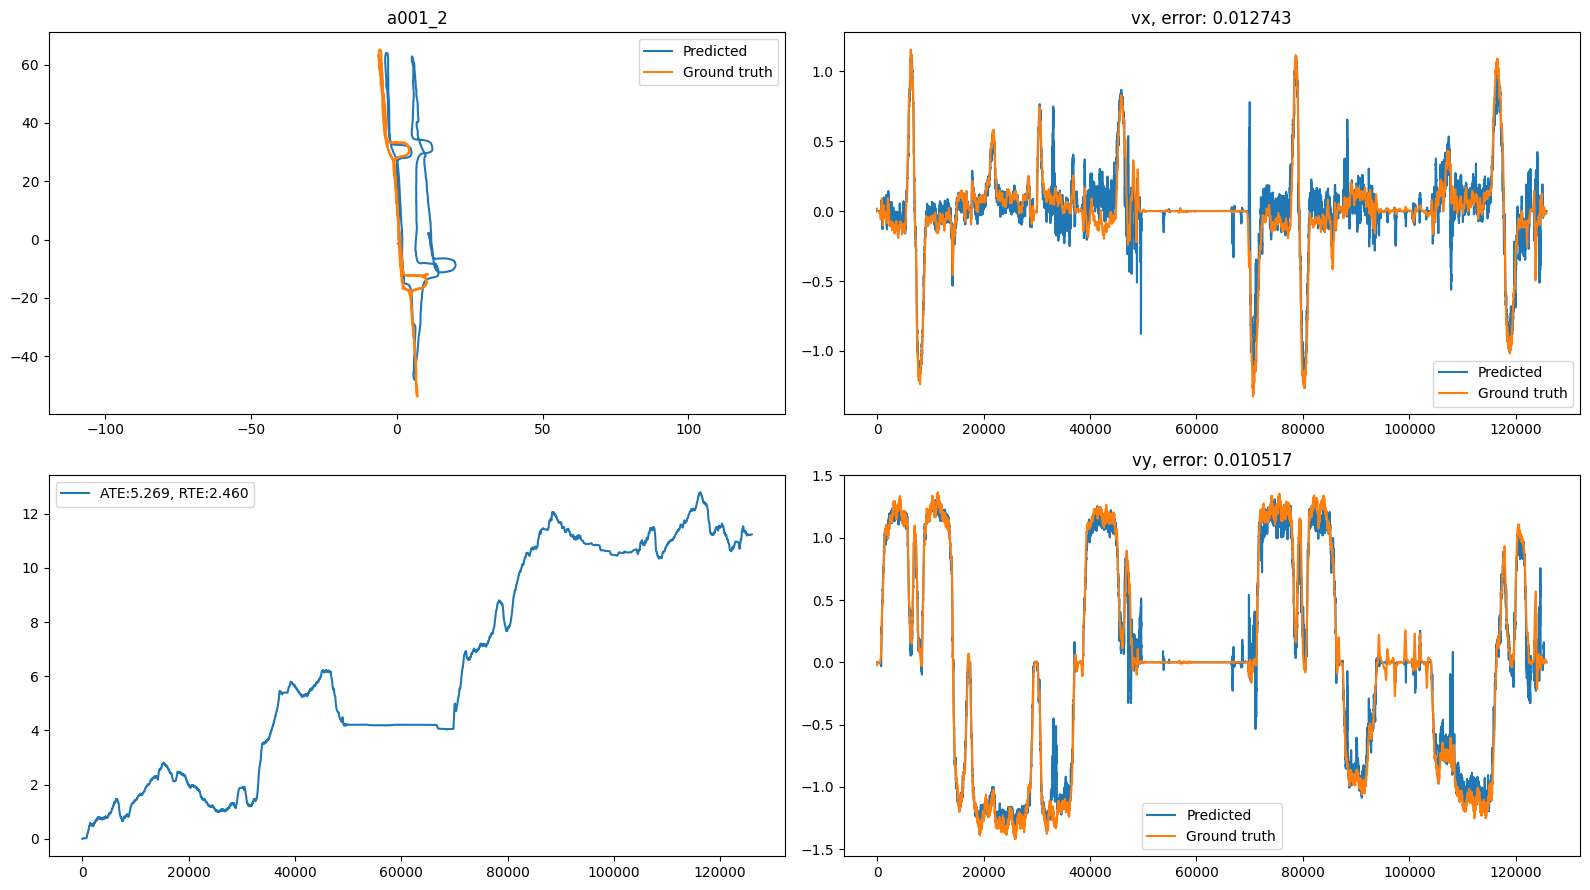

a003_3: device: samsung1, ori_error (game_rv): 1.669
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([510, 6, 200])
Target shape: torch.Size([510, 2])
targets (for prediction):  [[-0.007034 -0.003169]
 [-0.007668 -0.001623]
 [-0.008501 -0.000840]
 ...
 [0.043701 -0.003263]
 [0.042863 -0.003416]
 [0.040759 -0.003386]] s

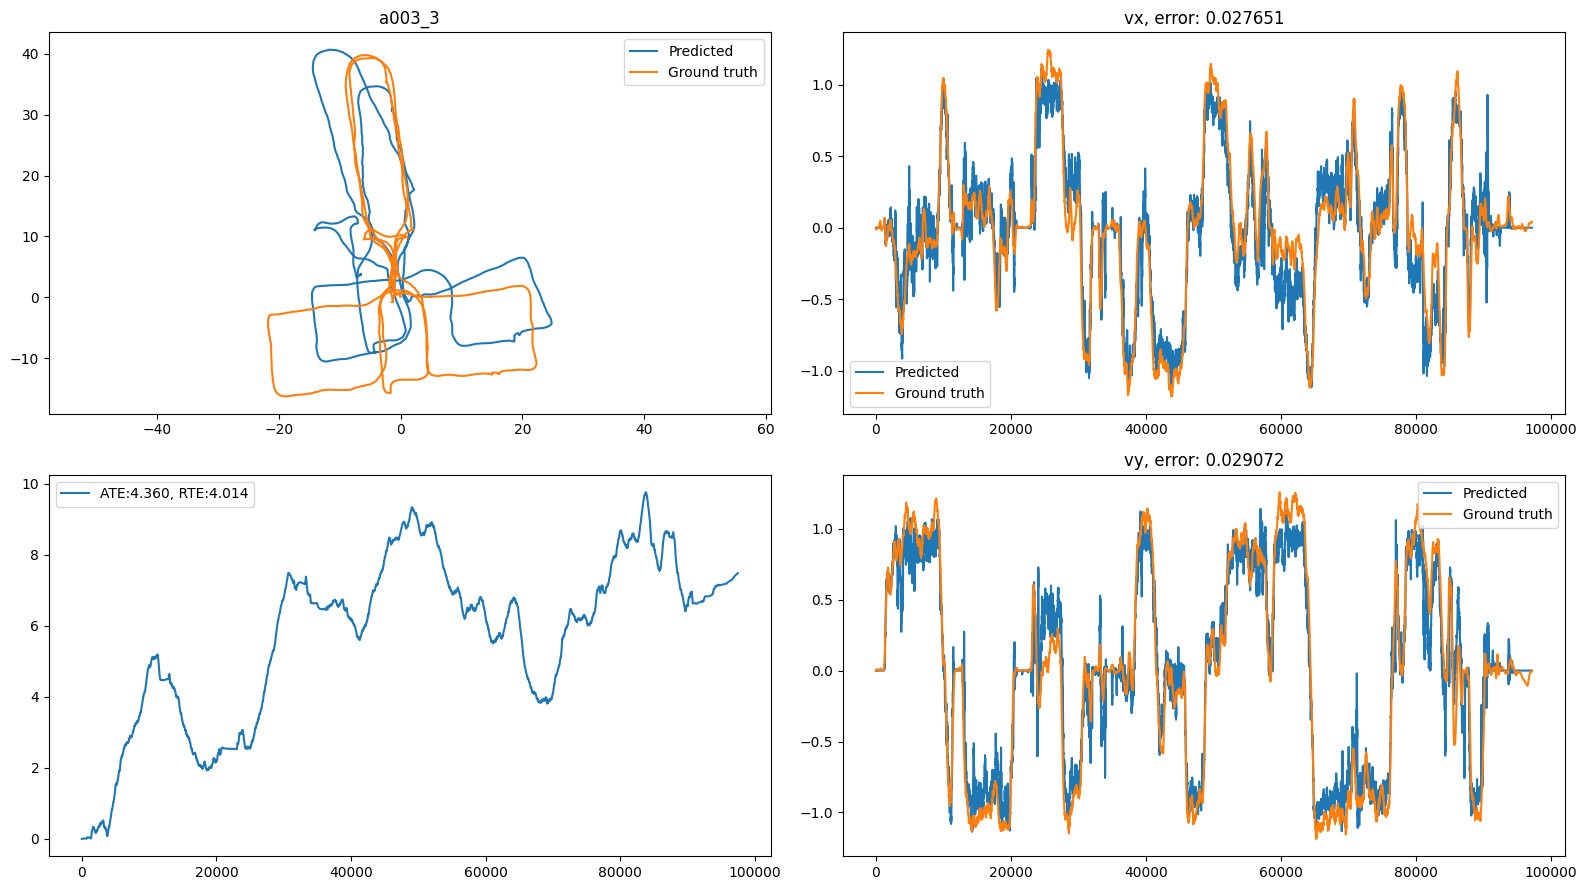

a004_3: device: asus3, ori_error (game_rv): 14.735
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1012, 6, 200])
Target shape: torch.Size([1012, 2])
targets (for prediction):  [[-0.002959 0.010150]
 [-0.003122 0.010287]
 [-0.003203 0.009980]
 ...
 [-0.016768 -0.009451]
 [-0.017198 -0.009637]
 [-0.017257 -0.009569]] shape (5108, 2)
actual targets:  [[-0.002959 0.010150]
 [-0.002973 0.010161]
 [-0.002987 0.010172]
 ...
 [-0.017236 -0.009544]
 [-0.017211 -0.009516]
 [-0.017179 -0.009483]] shape (51074, 2)
Sequence a004_3, loss [0.012128 0.013443] / 0.01278555579483509, ate 2.782742, rte 2.078947


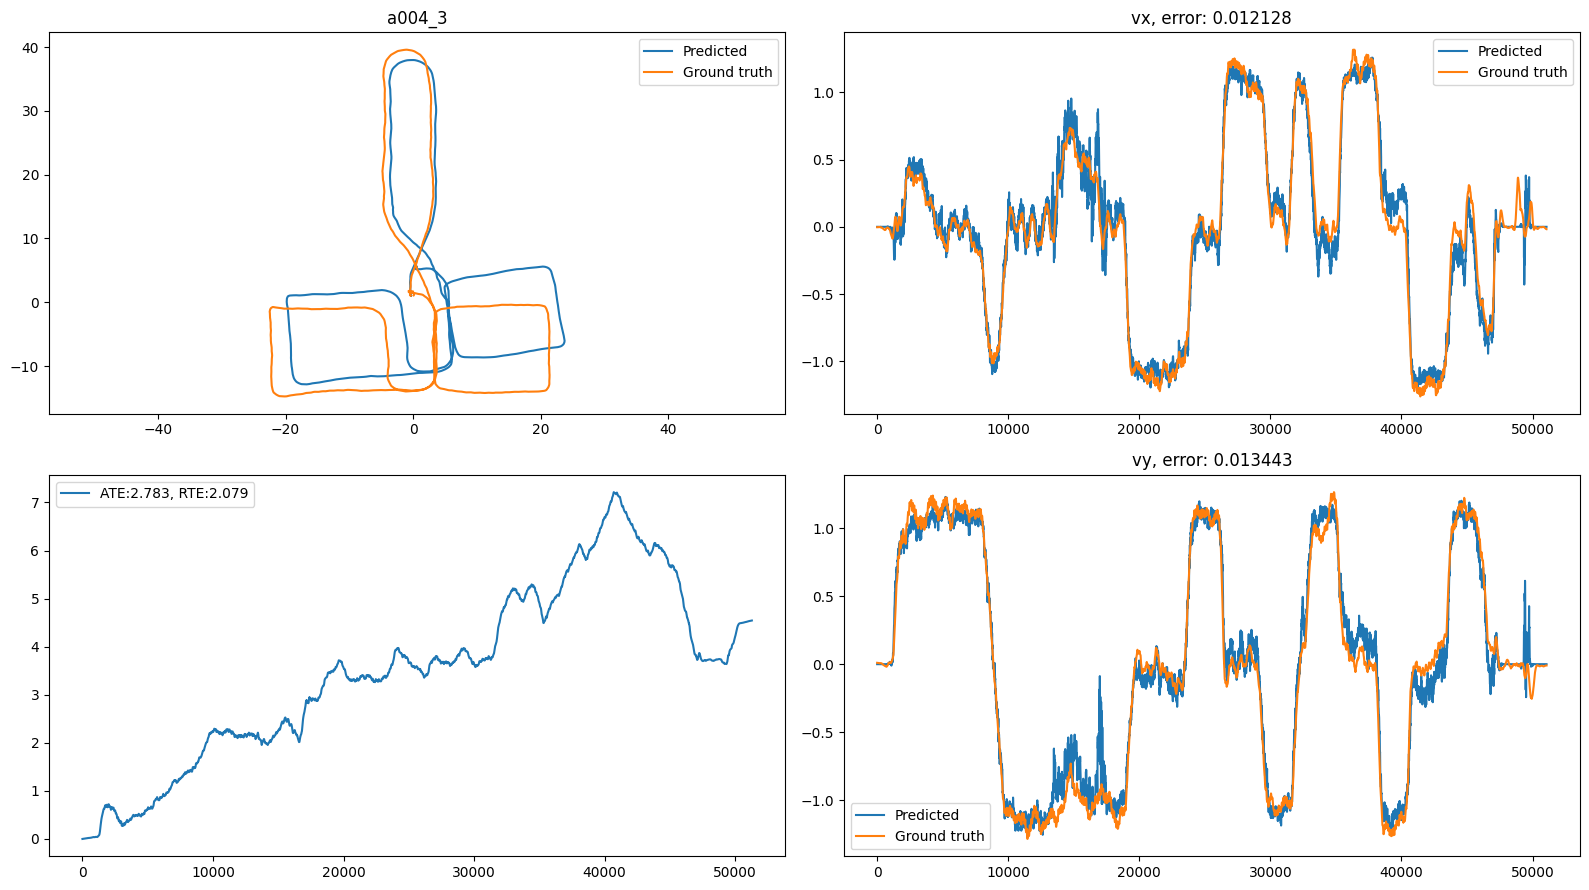

a005_3: device: samsung1, ori_error (game_rv): 1.271
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([531, 6, 200])
Target shape: torch.Size([531, 2])
targets (for 

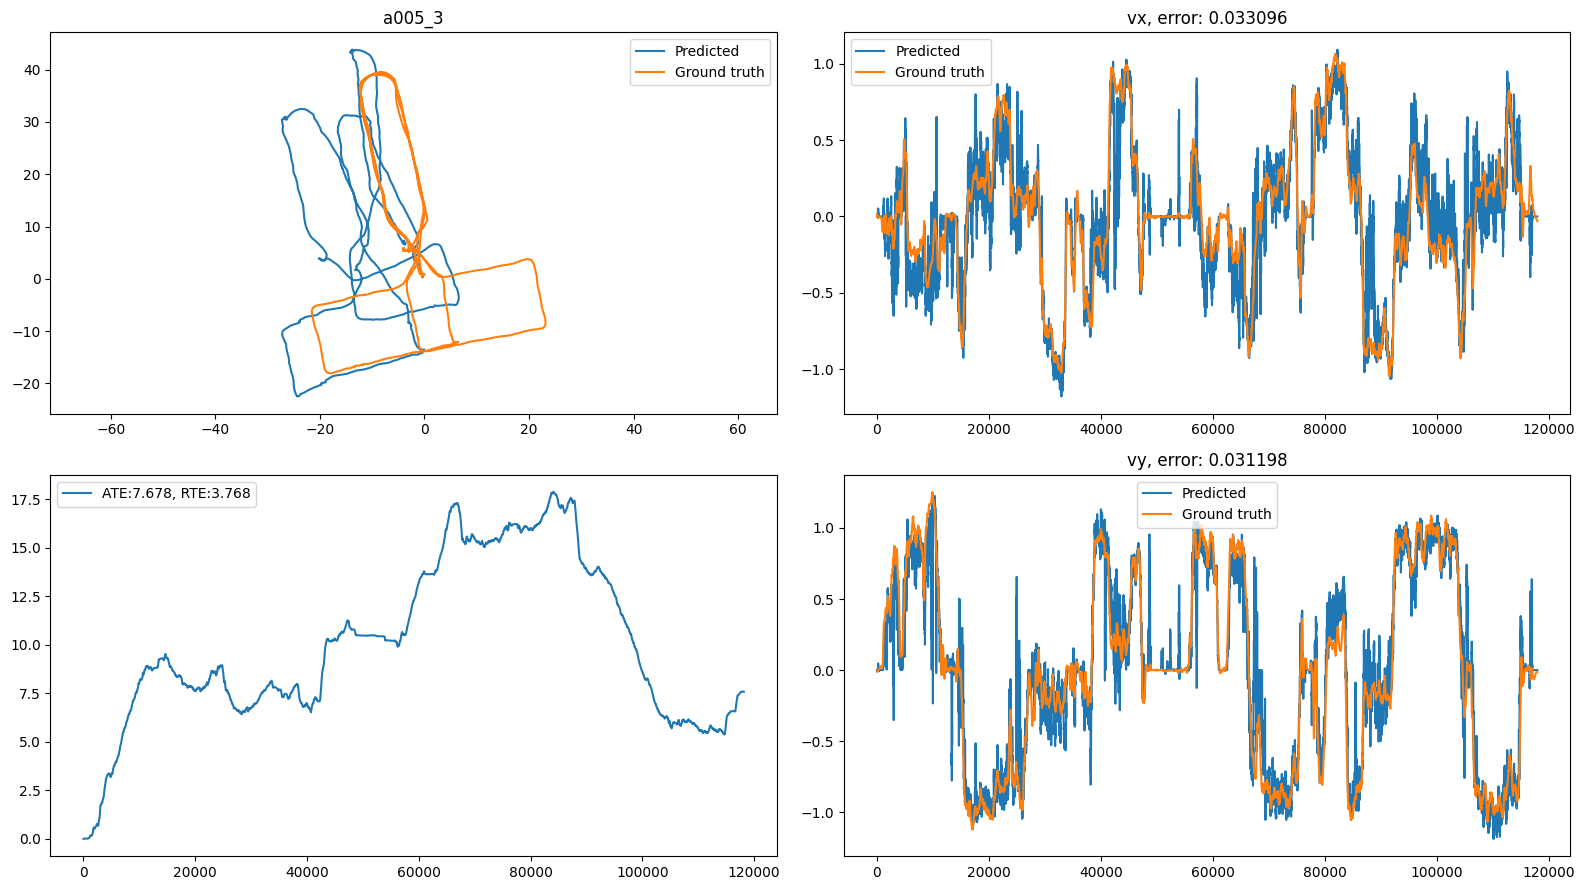

a009_1: device: asus4, ori_error (game_rv): 2.222
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([70, 6, 200])
Target shape: torch.Size([70, 2])
targets (for prediction):  [[-0.029292 0.035714]
 [-0.011979 0.041471]
 [0.004921 0.048020]
 ...
 [-0.010329 0.049827]
 [-0.010340 0.048990]
 [-0.010396 0.048388]] shape (8262, 2)
actual targets:  [[-0.029292 0.035714]
 [-0.027556 0.036250]
 [-0.025814

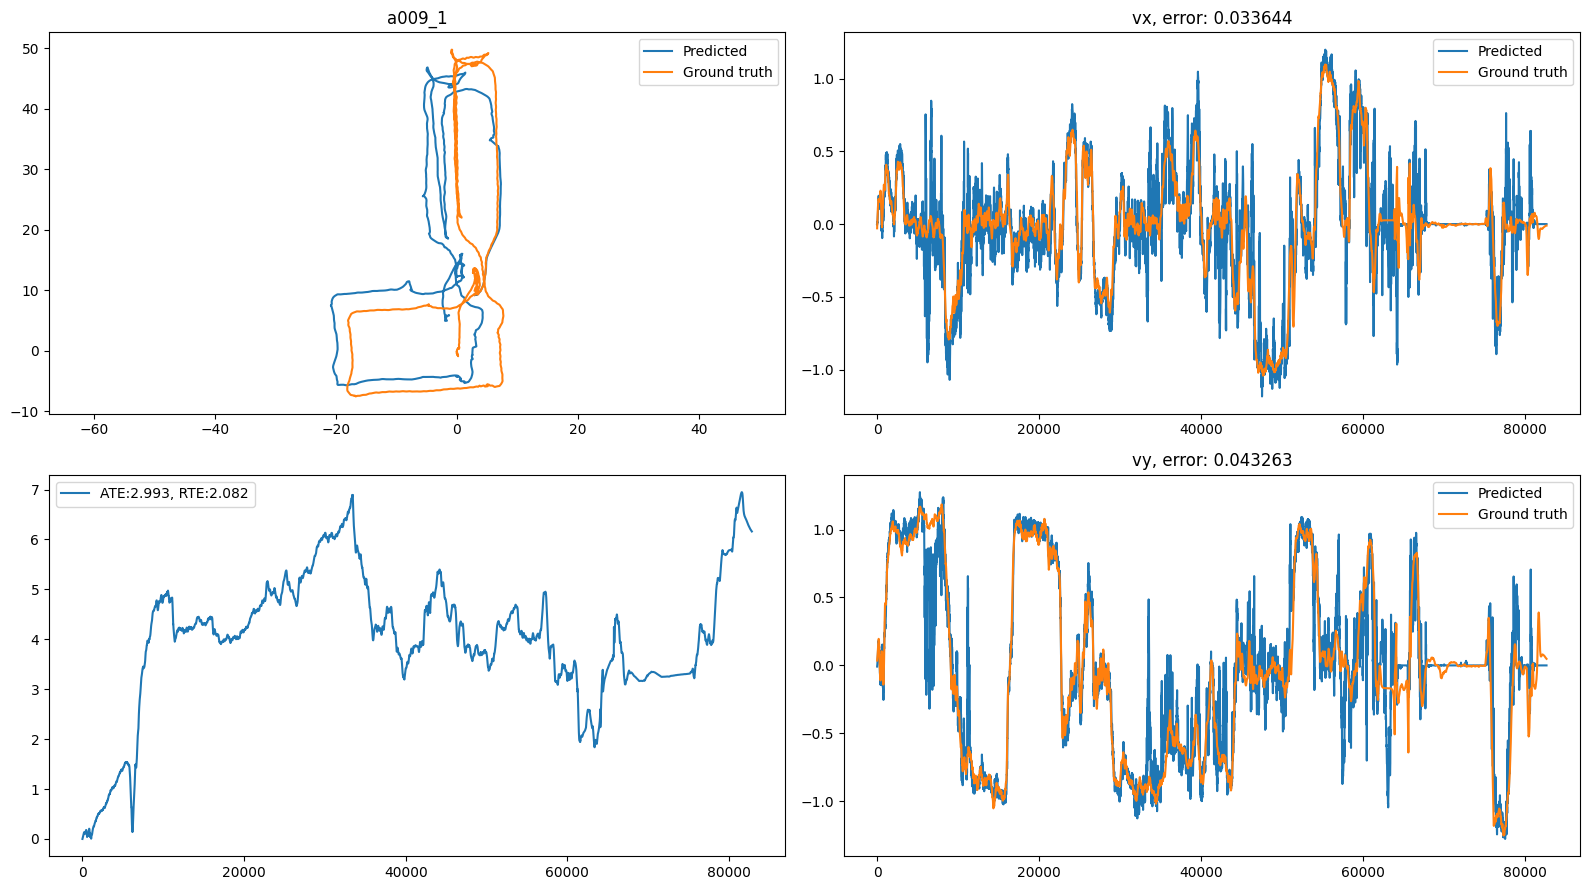

a010_2: device: samsung1, ori_error (game_rv): 17.991
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature sh

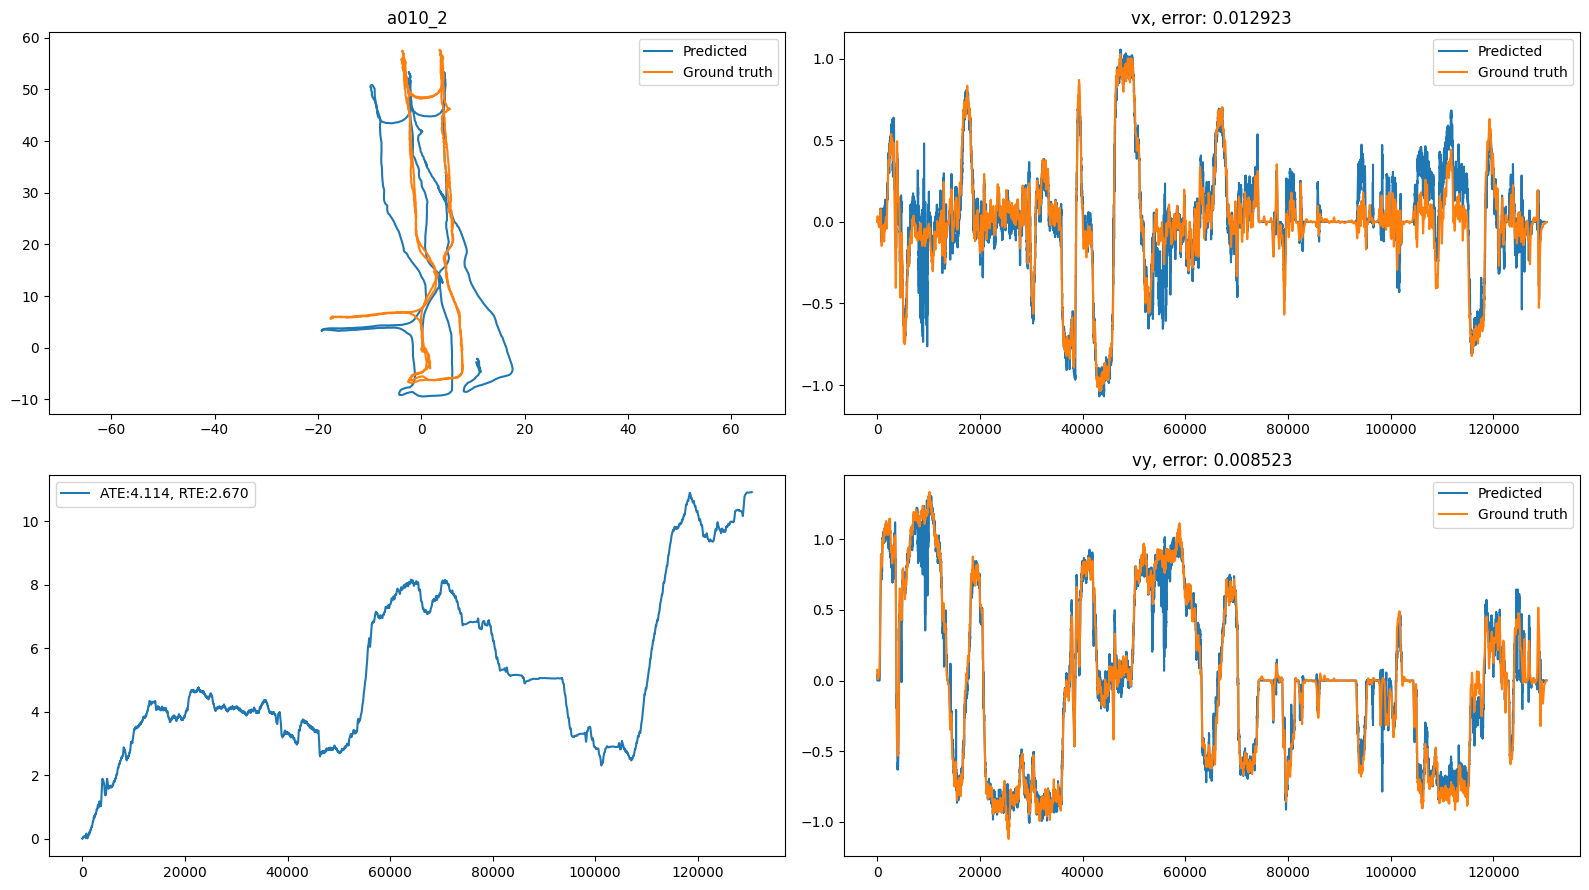

a011_2: device: samsung1, ori_error (game_rv): 30.493
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature sh

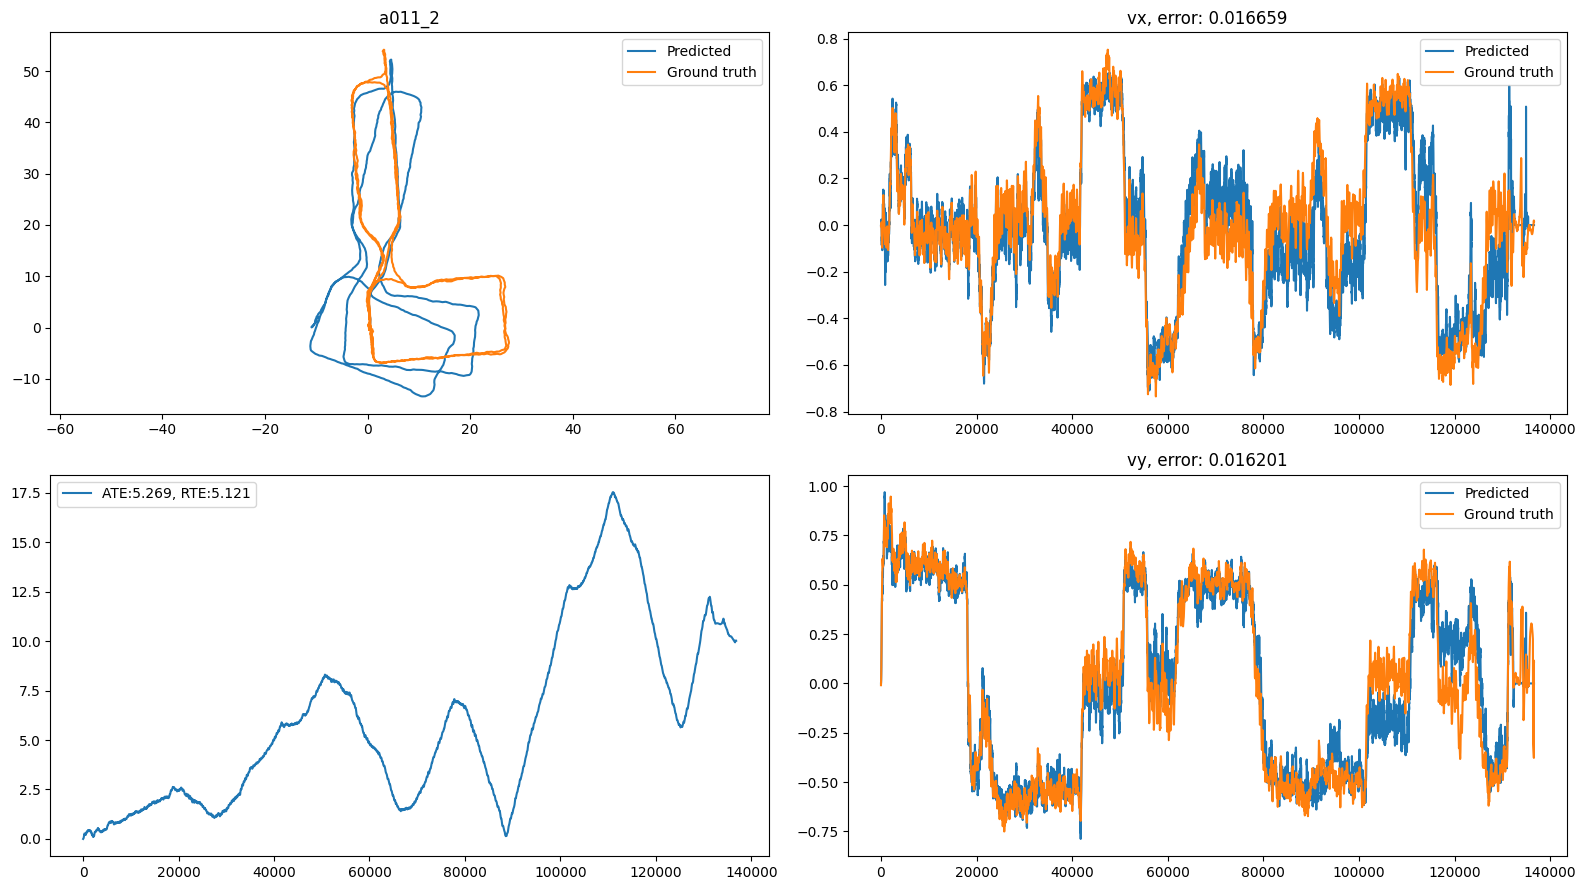

a012_2: device: samsung1, ori_error (game_rv): 4.979
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([577, 6, 200])
Target shape: torch.Size([577, 2])
targets (for 

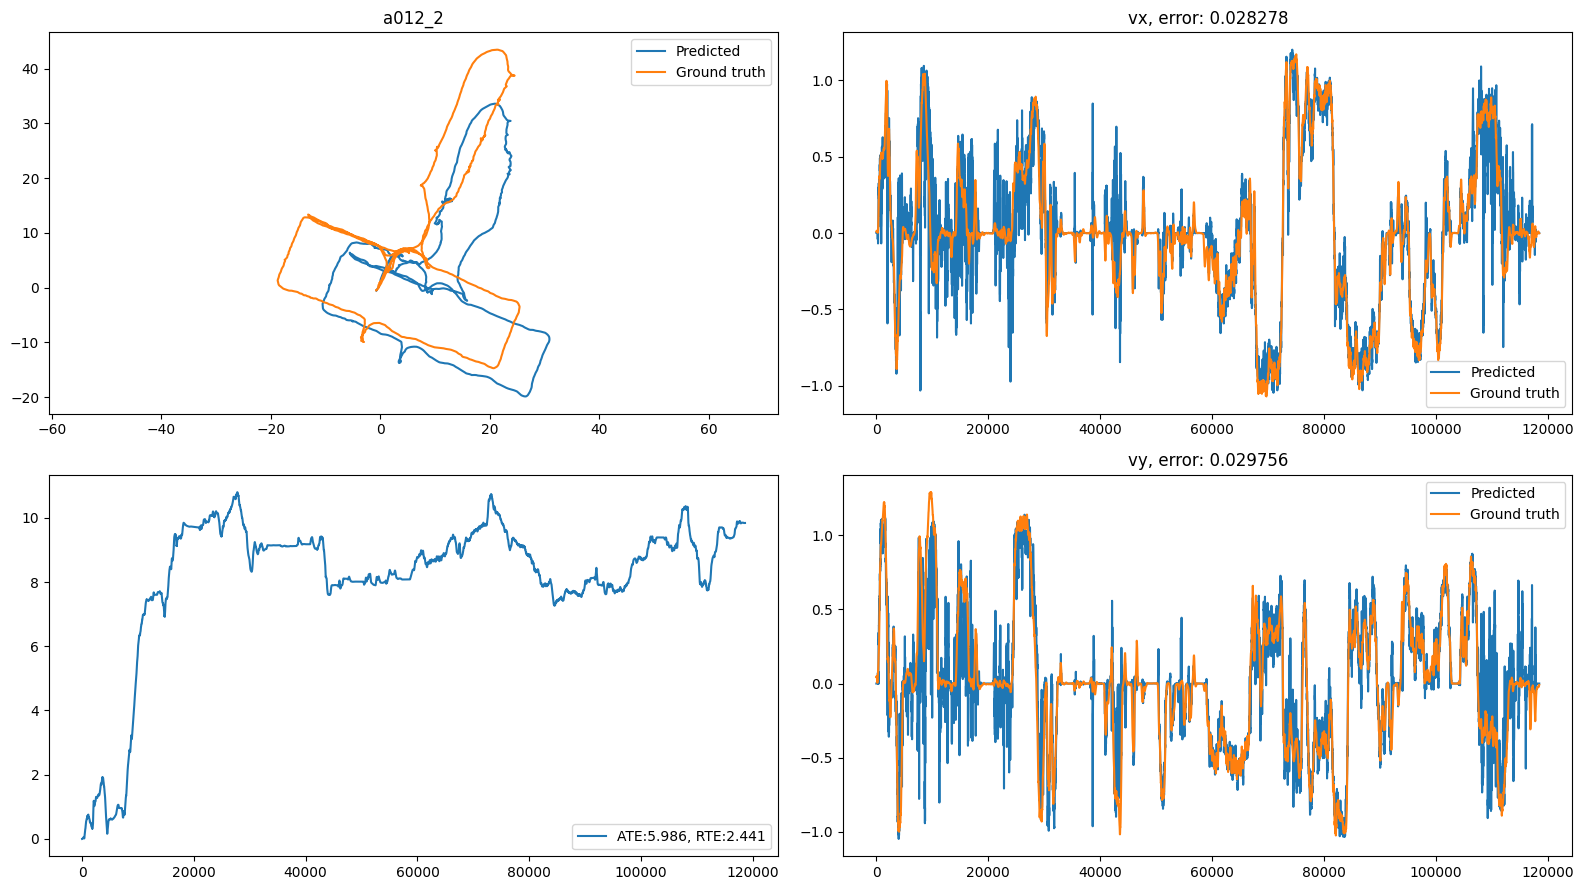

a013_2: device: asus4, ori_error (game_rv): 5.244
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape:

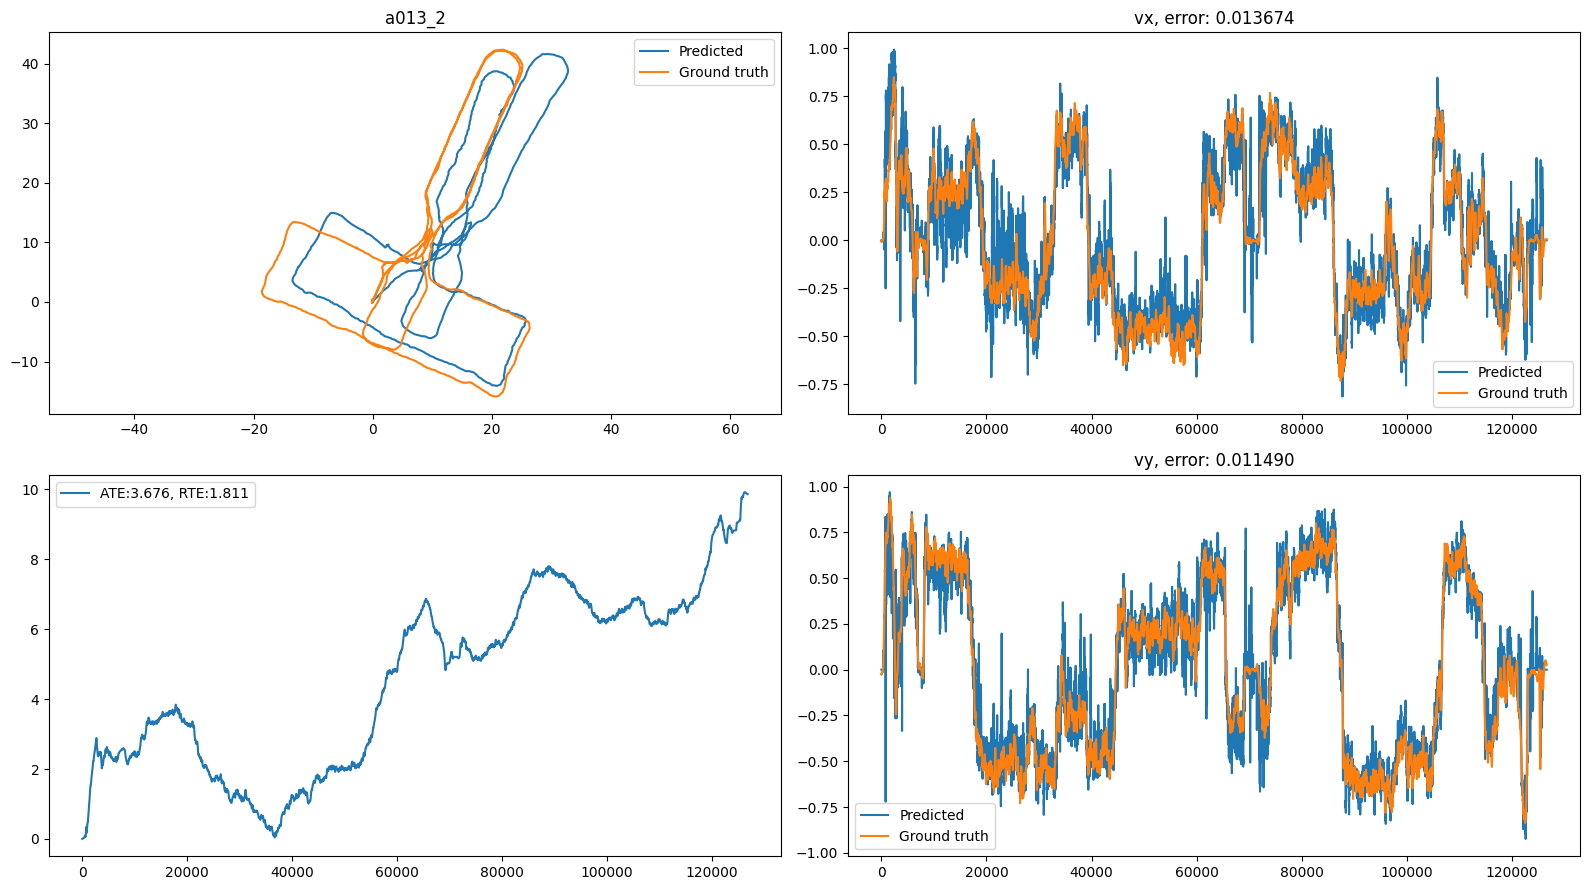

a014_2: device: asus4, ori_error (game_rv): 7.929
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([252, 6, 200])
Target shape: torch.Size([252, 2])
targets (for pre

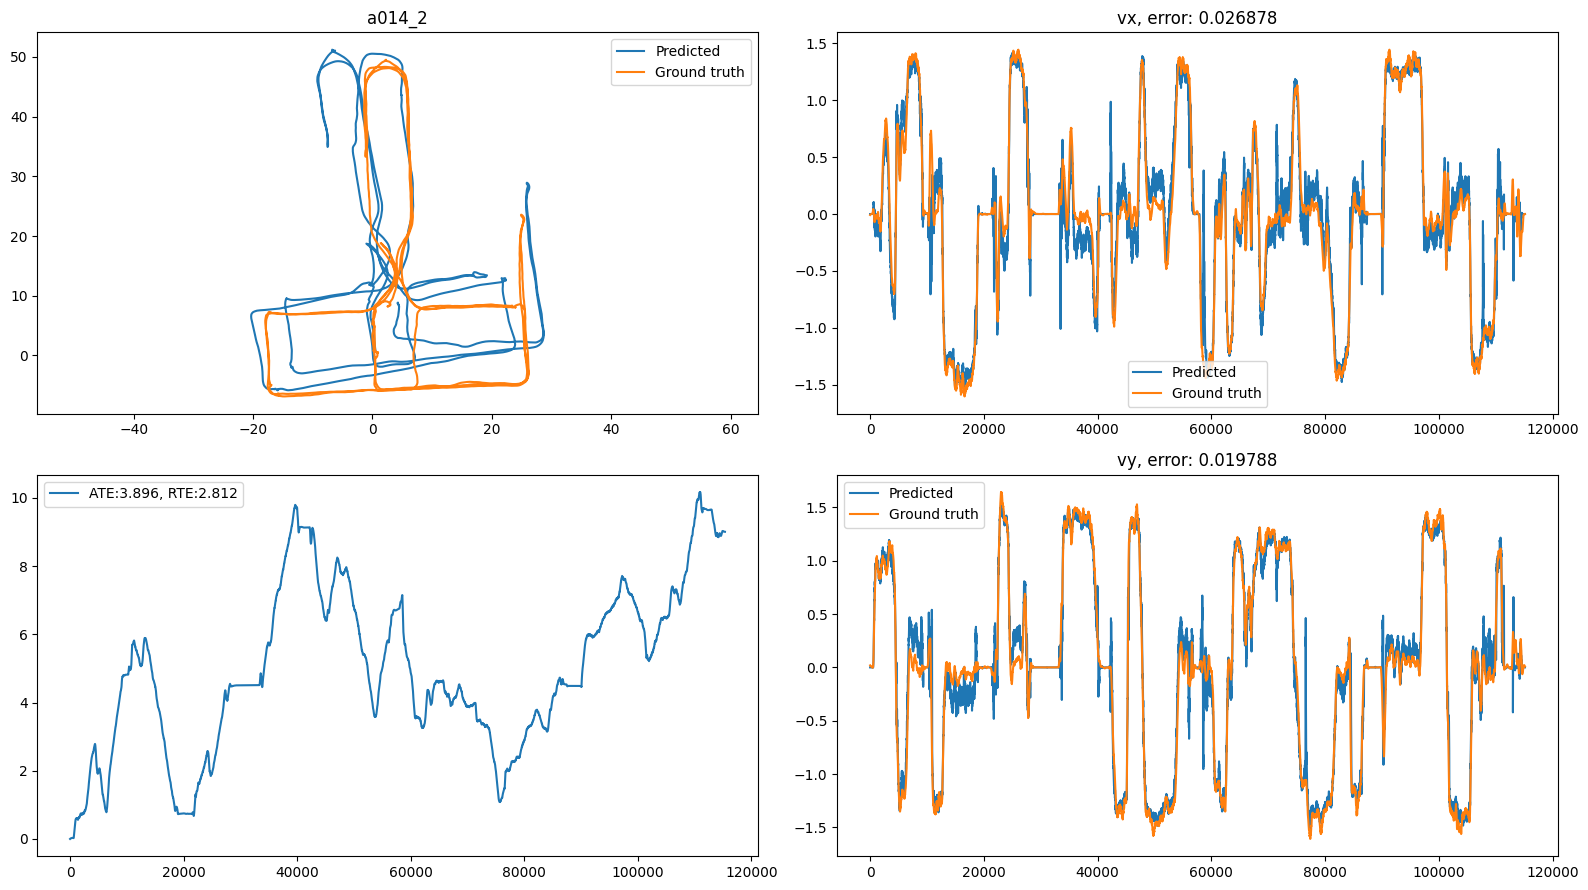

a016_1: device: asus4, ori_error (game_rv): 5.513
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([699, 6, 200])
Target shape: torch.Size([699, 2])
targets (for prediction):  [[0.061143 0.011216]
 [0.054873 0.013224]
 [0.048009 0.013828]
 ...
 [-0.013749 -0.009549]
 [-0.014263 -0.009361]
 [-0.014791 -0.009389]] shape (8891, 2)
actual targets:  [[0.061143 0.011216]
 [0.060569 0.011471]
 [0.059979

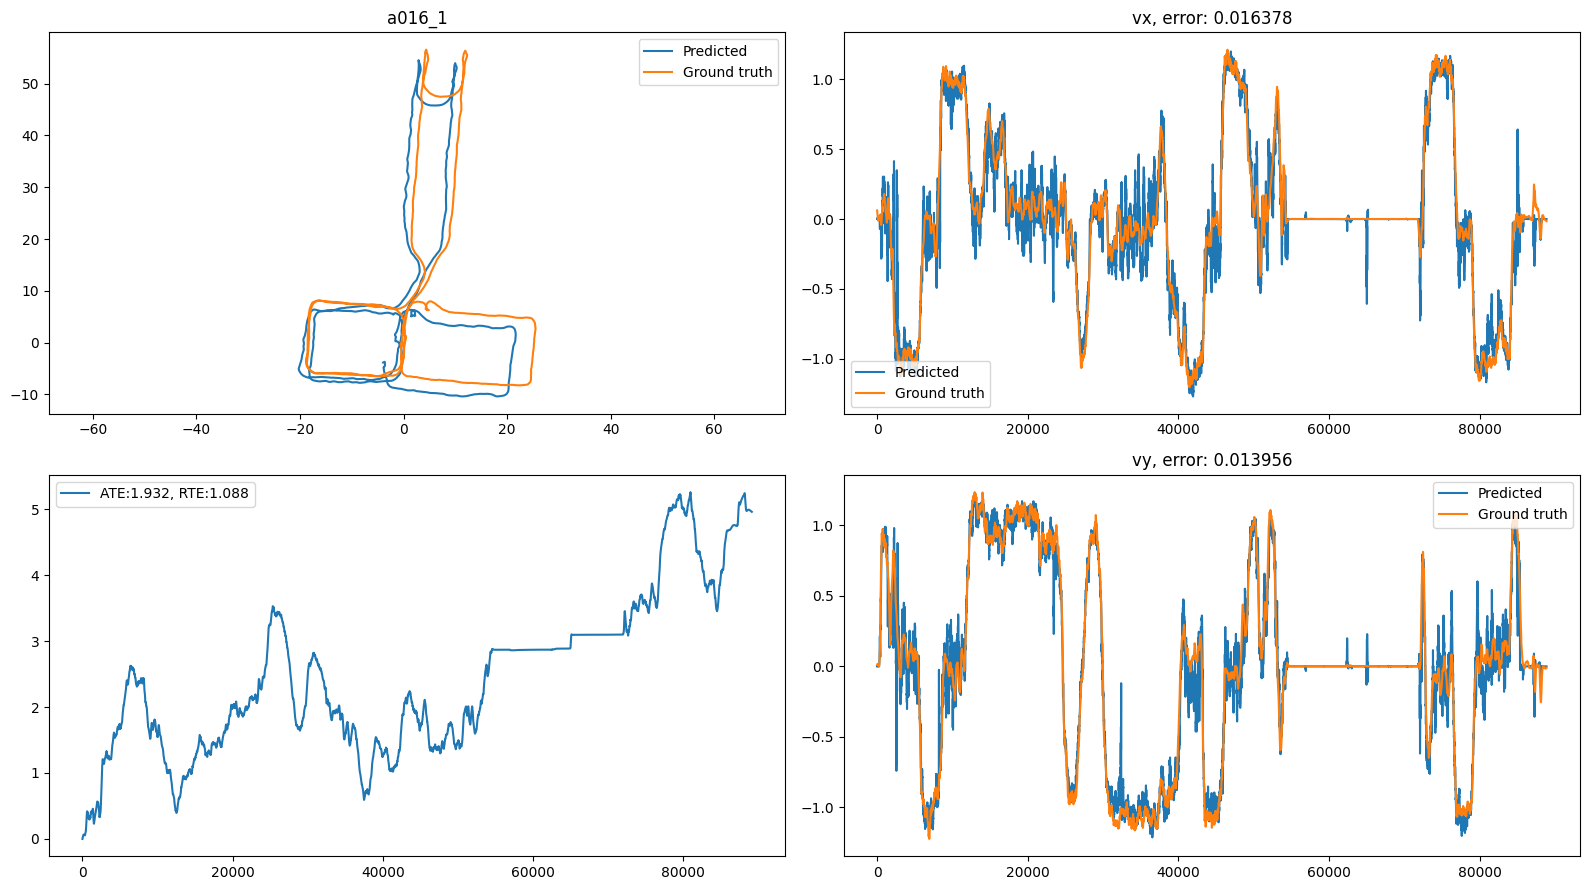

a017_2: device: samsung1, ori_error (game_rv): 4.091
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature sha

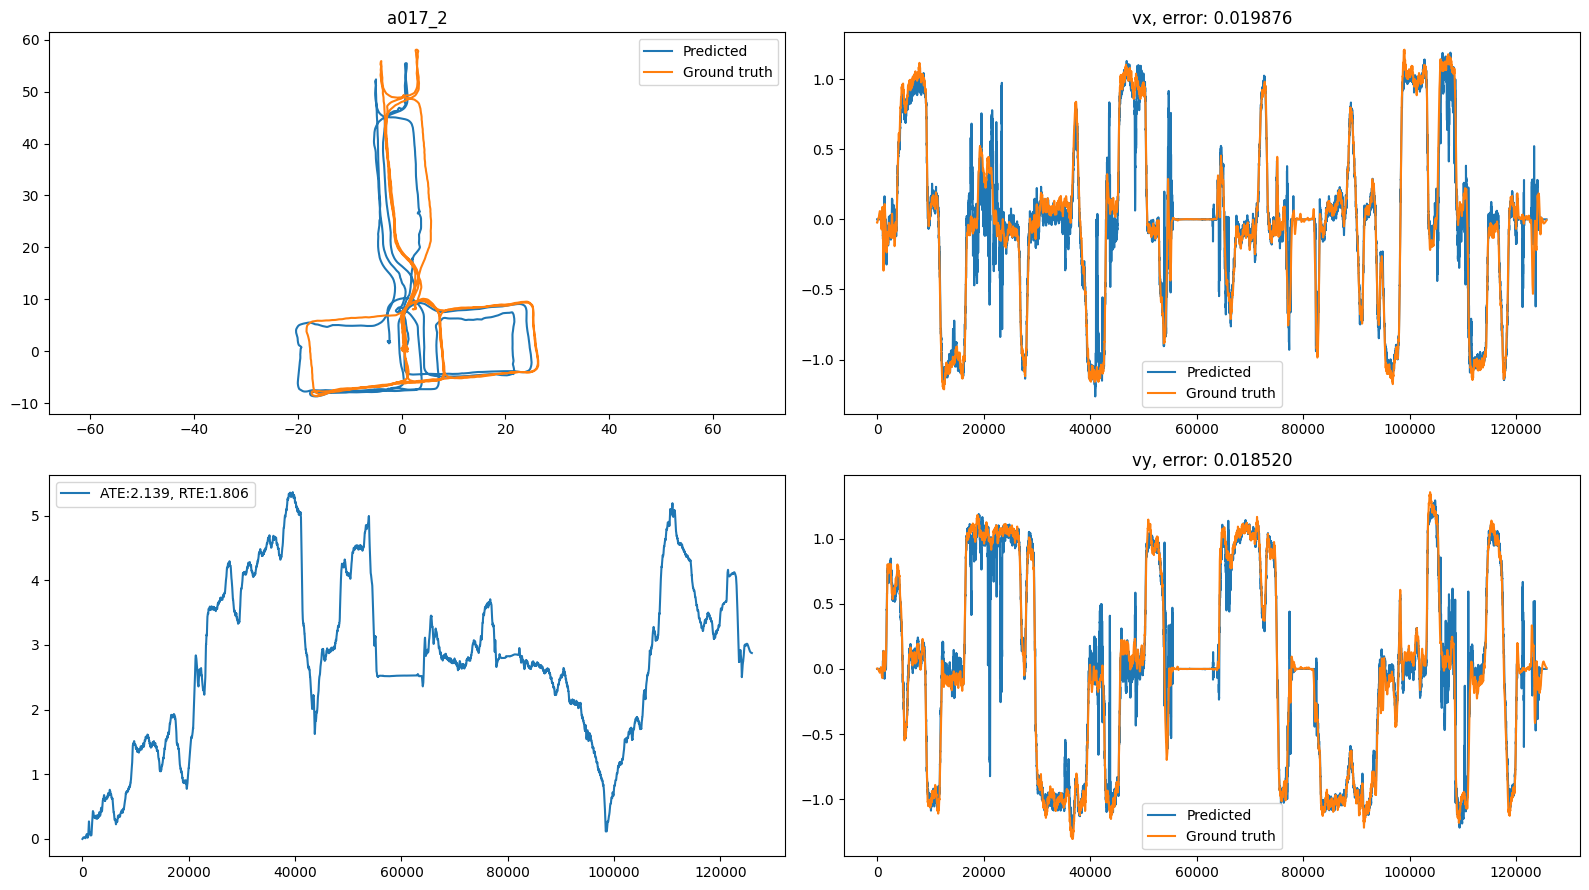

a020_2: device: asus3, ori_error (game_rv): 3.441
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([420, 6, 200])
Target shape: torch.Size([420, 2])
targets (for prediction):  [[0.000327 0.002363]
 [0.000266 0.002210]
 [0.000237 0.002071]
 ...
 [0.013443 0.020325]
 [0.012854 0.021519]
 [0.012178 0.022788]] shape (7588, 2)
actual targets:  [[0.000327 0.002363]
 [0.000316 0.002351]
 [0.000306 0.002338]
 ...
 [0.012178 0.022788]
 [0.012096 0.022913]
 [0.012013 0.023040]] shap

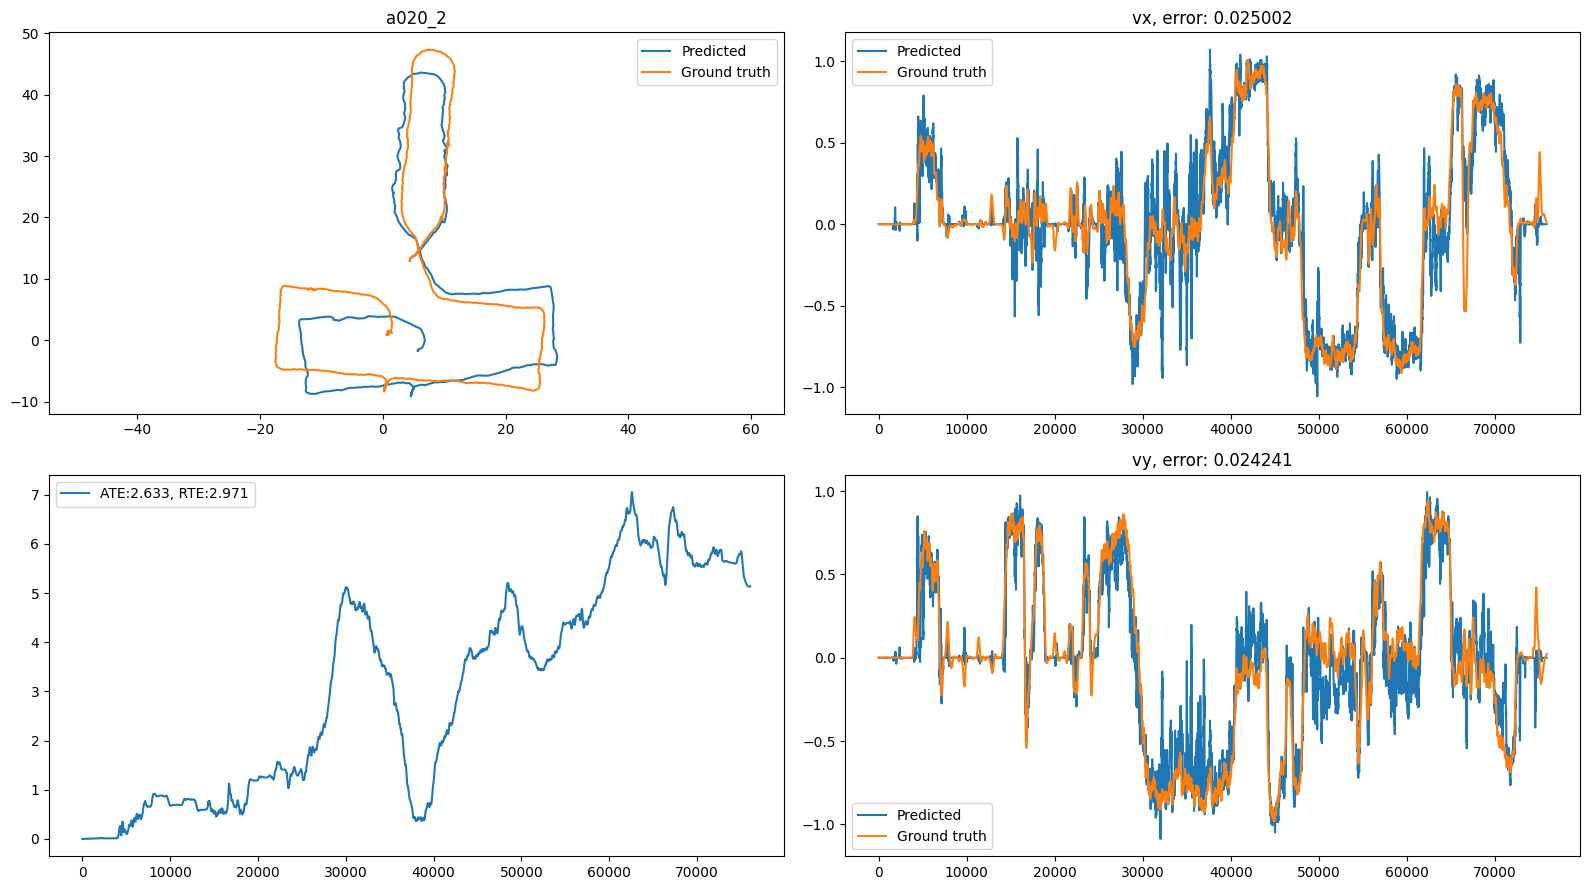

a021_2: device: samsung1, ori_error (game_rv): 6.462
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([150, 6, 200])
Target shape: torch.Size([150, 2])
targets (for 

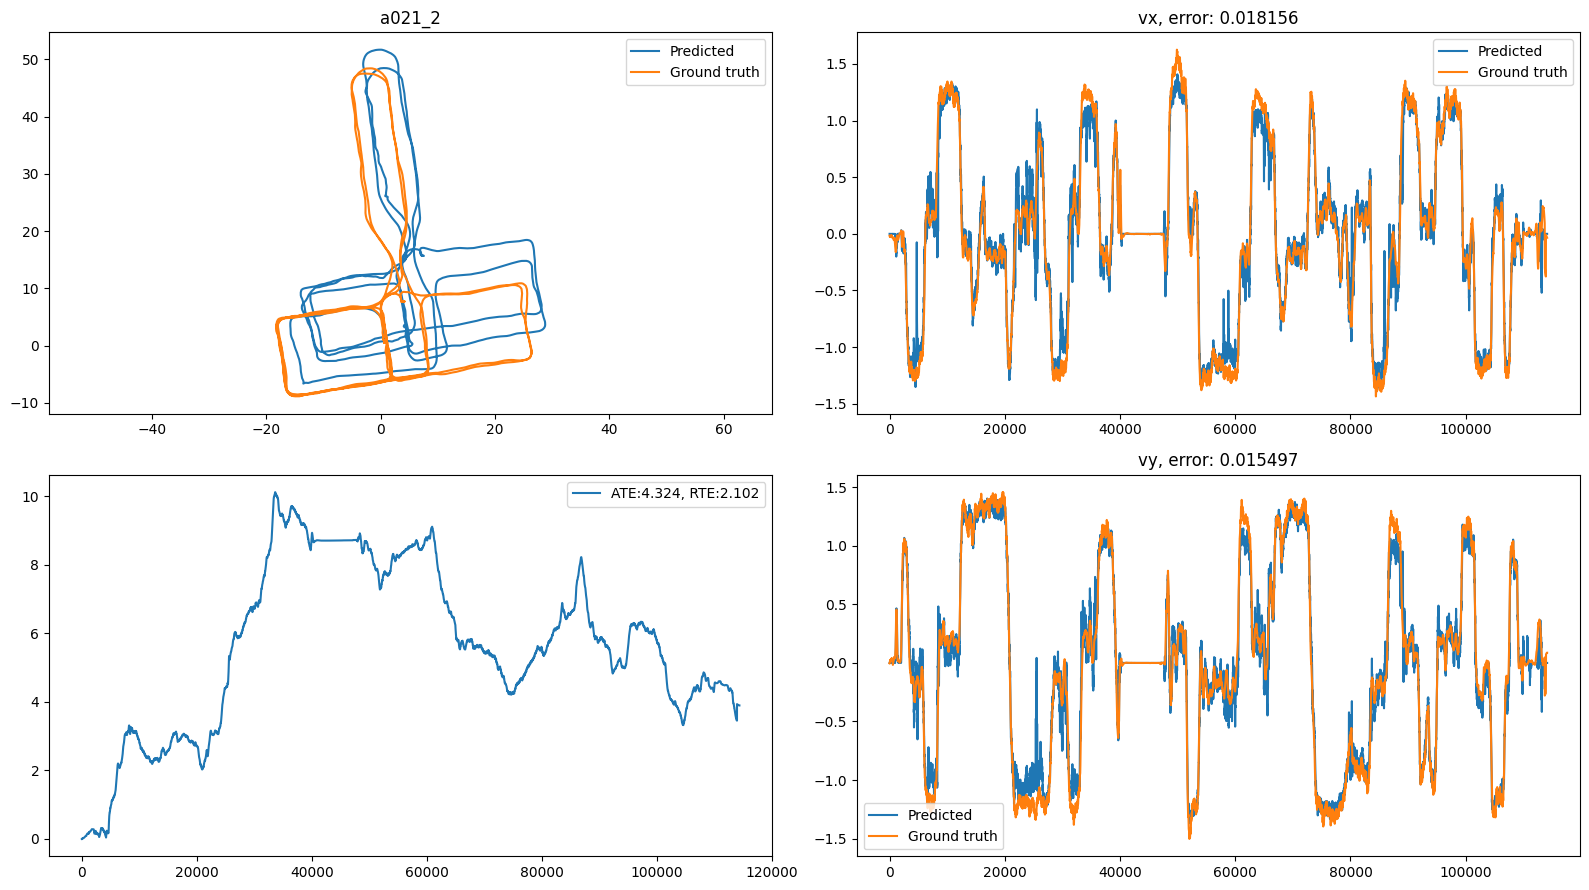

a022_2: device: asus5, ori_error (game_rv): 3.583
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([832, 6, 200])
Target shape: torch.Size([832, 2])
targets (for prediction):  [[0.002205 -0.006526]
 [0.002455 -0.008580]
 [0.002707 -0.009657]
 

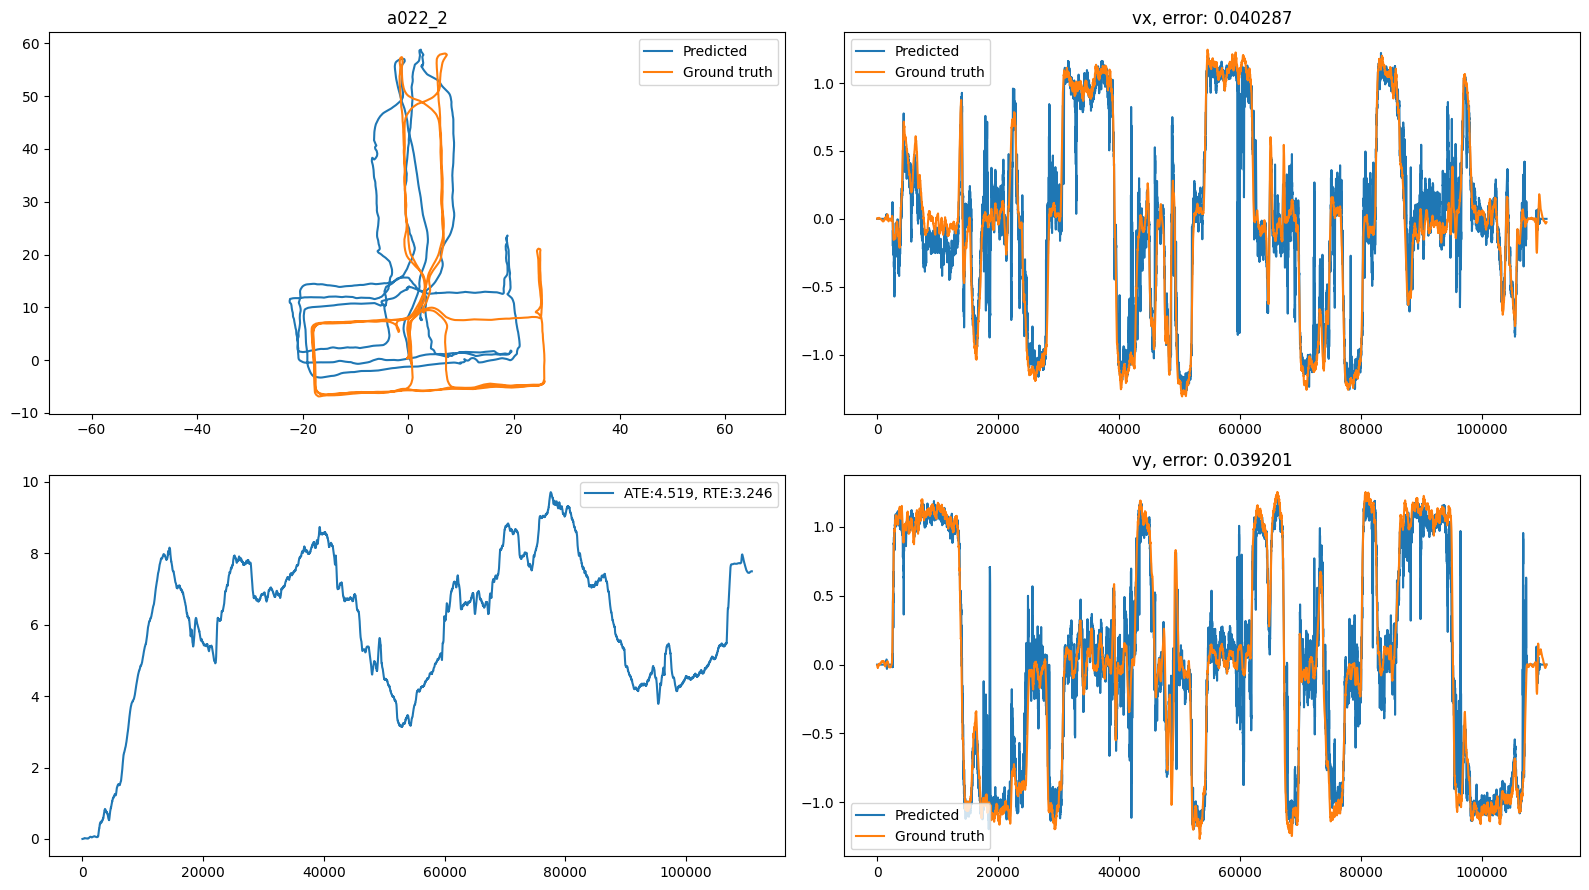

a023_1: device: asus5, ori_error (game_rv): 7.791
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([698, 6, 200])
Target shape: torch.Size([698, 2])
targets (for prediction):  [[-0.001019 0.014647]
 [-0.000785 0.013663]
 [-0.000733 0.012741]
 ...
 [-0.009427 -0.000659]
 [-0.011260 0.000334]
 [-0.012824 0.001285]] shape (7866, 2)
actual targets:  [[-0.001019 0.014647]
 [-0.000991 0.014547]
 [-0.000963 0.014446]
 ...
 [-0.013245 0.001563]
 [-0.013387 0.001632]
 [-0.013529 0.

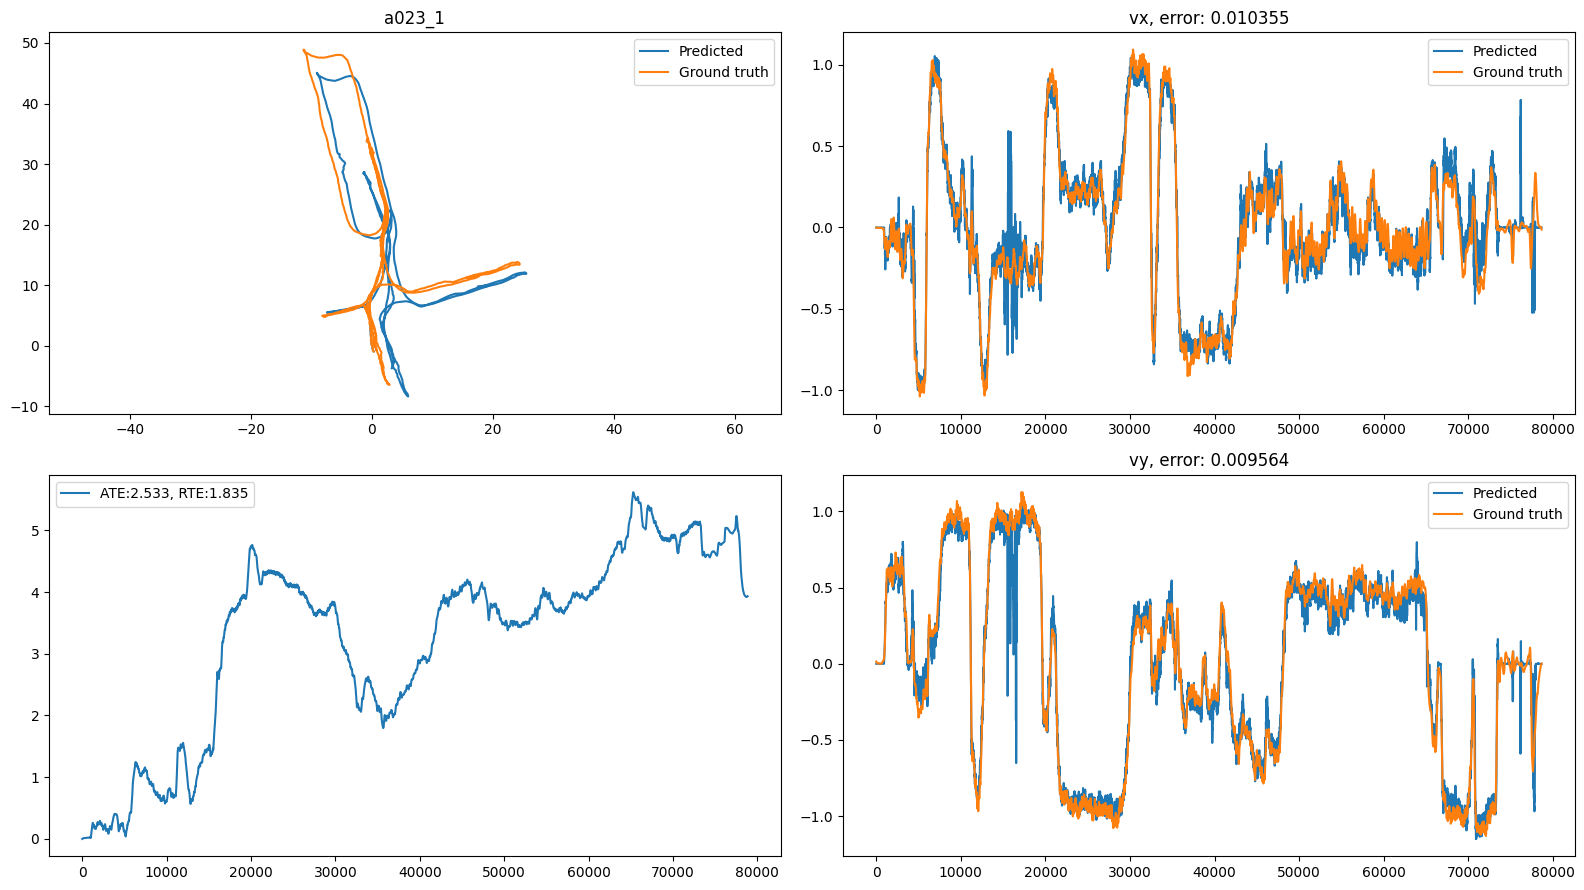

a025_2: device: samsung1, ori_error (game_rv): 2.222
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature sha

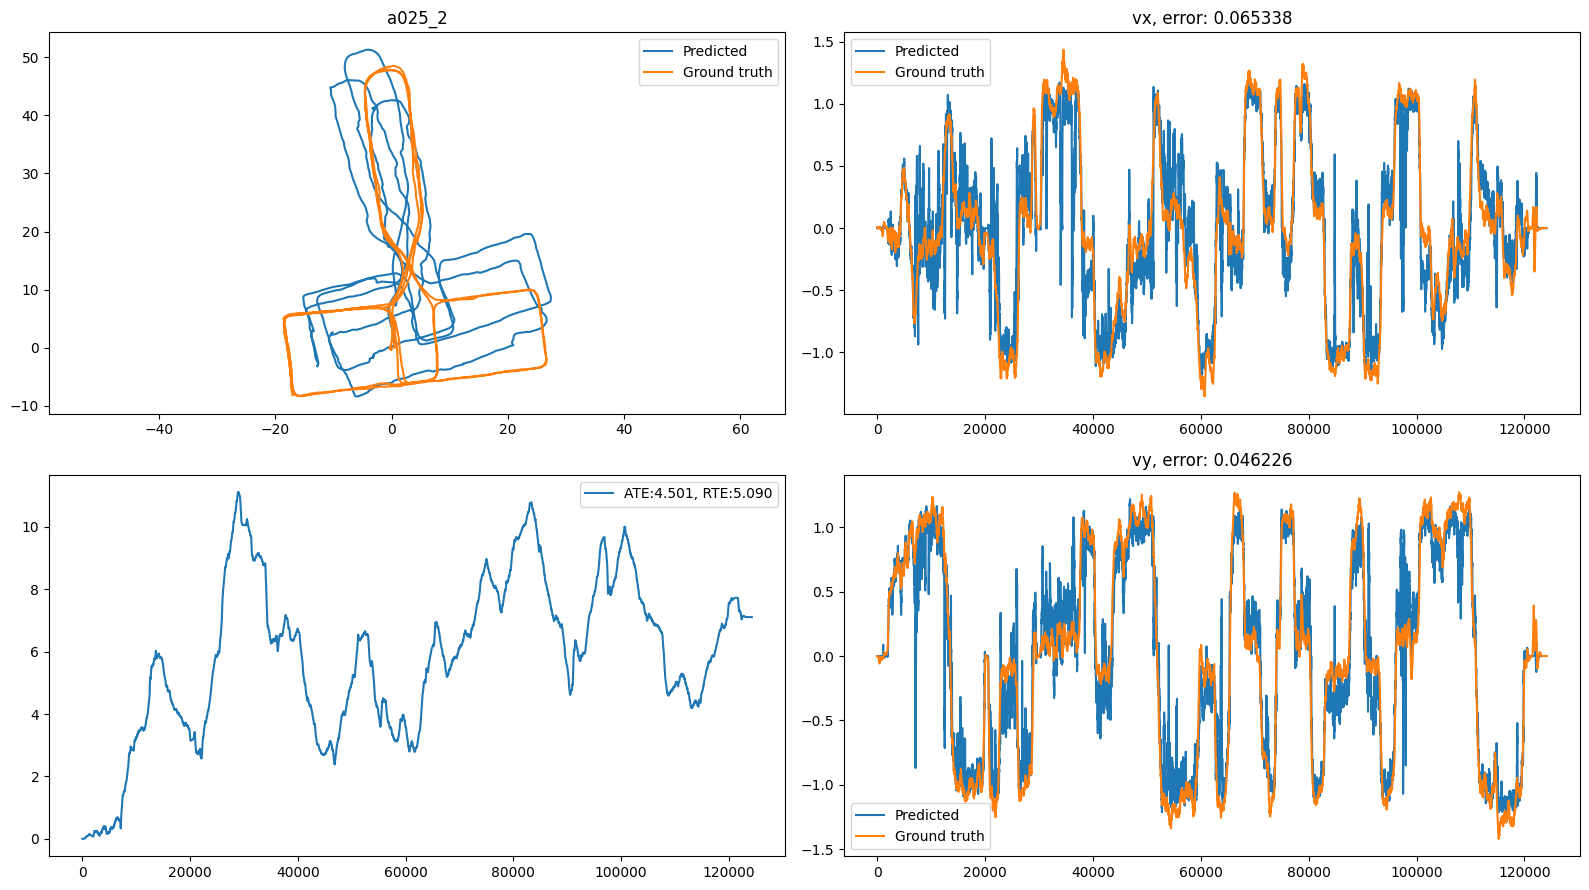

a026_2: device: asus4, ori_error (game_rv): 8.912
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([657, 6, 200])
Target shape: torch.Size([657, 2])
targets (for pre

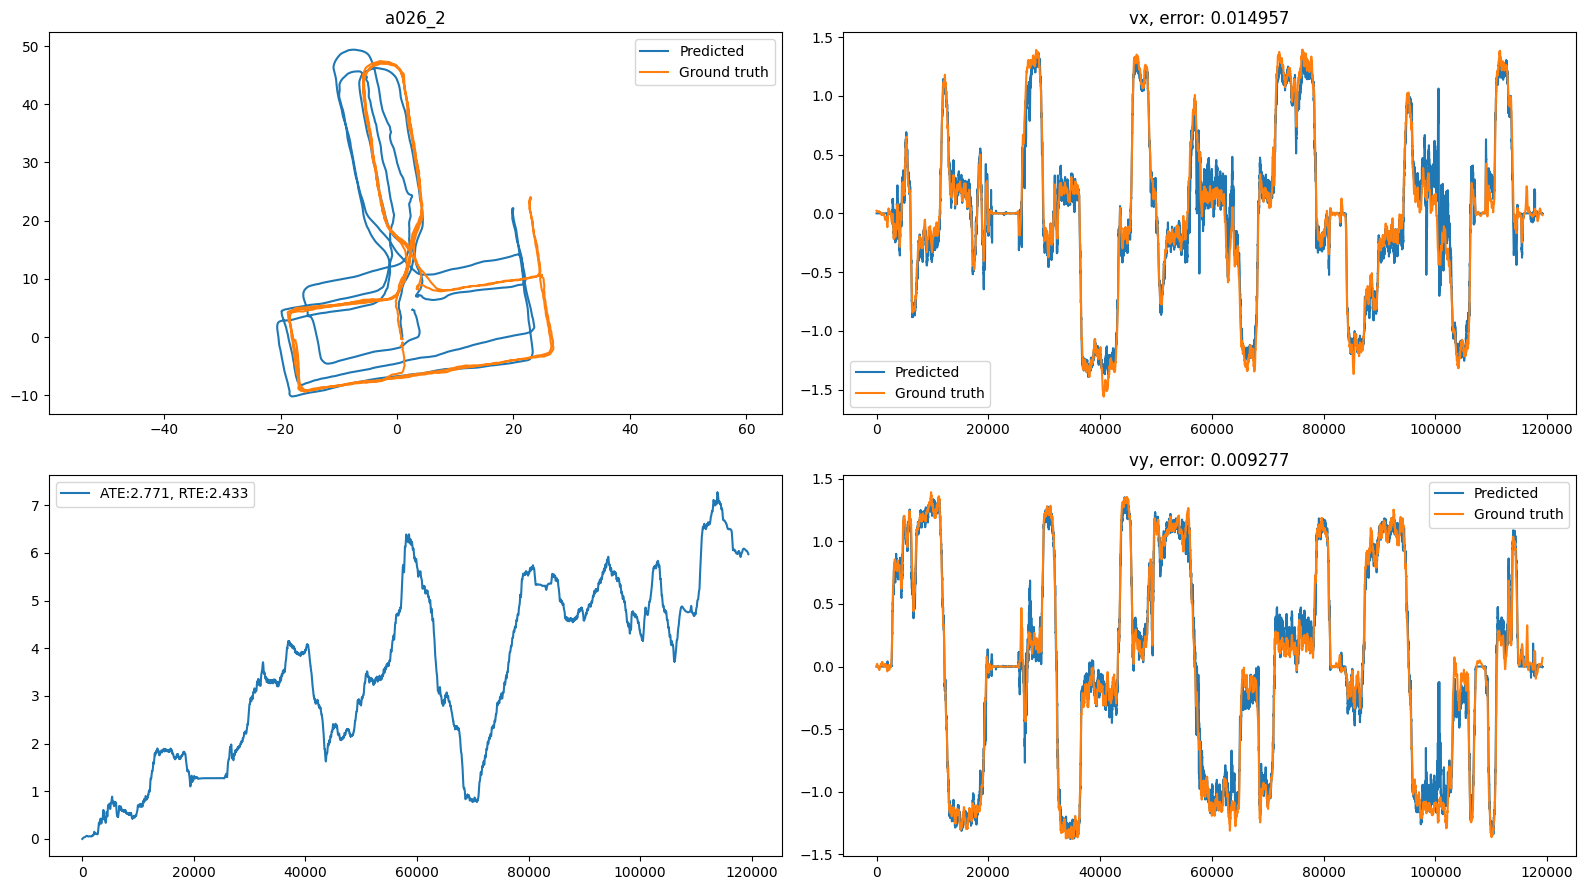

a027_2: device: samsung1, ori_error (game_rv): 11.382
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature sh

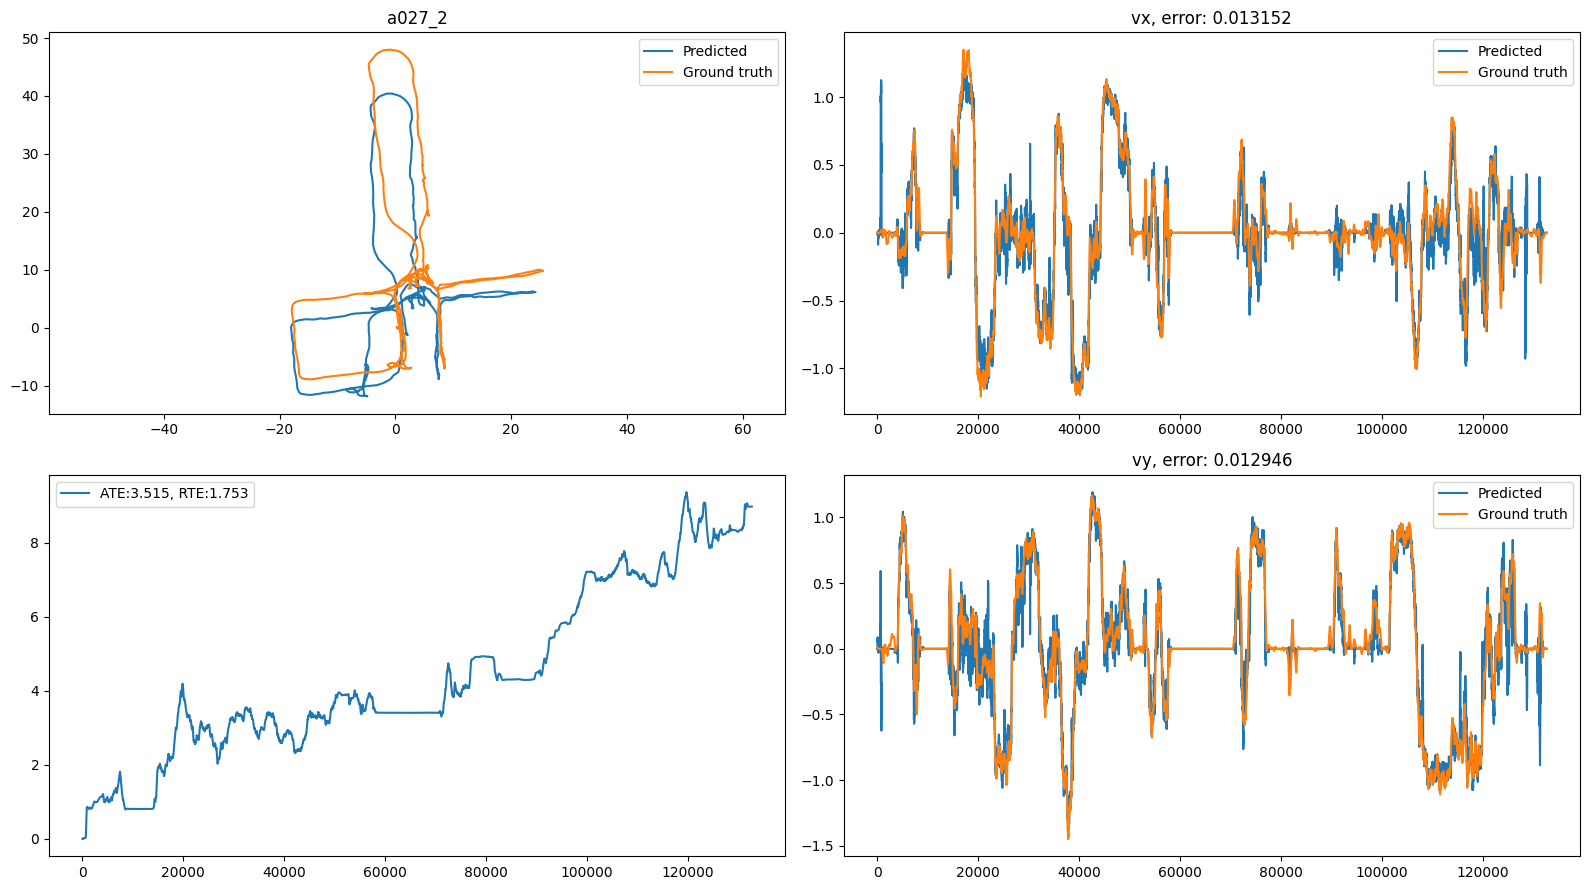

a030_3: device: samsung1, ori_error (game_rv): 5.627
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature sha

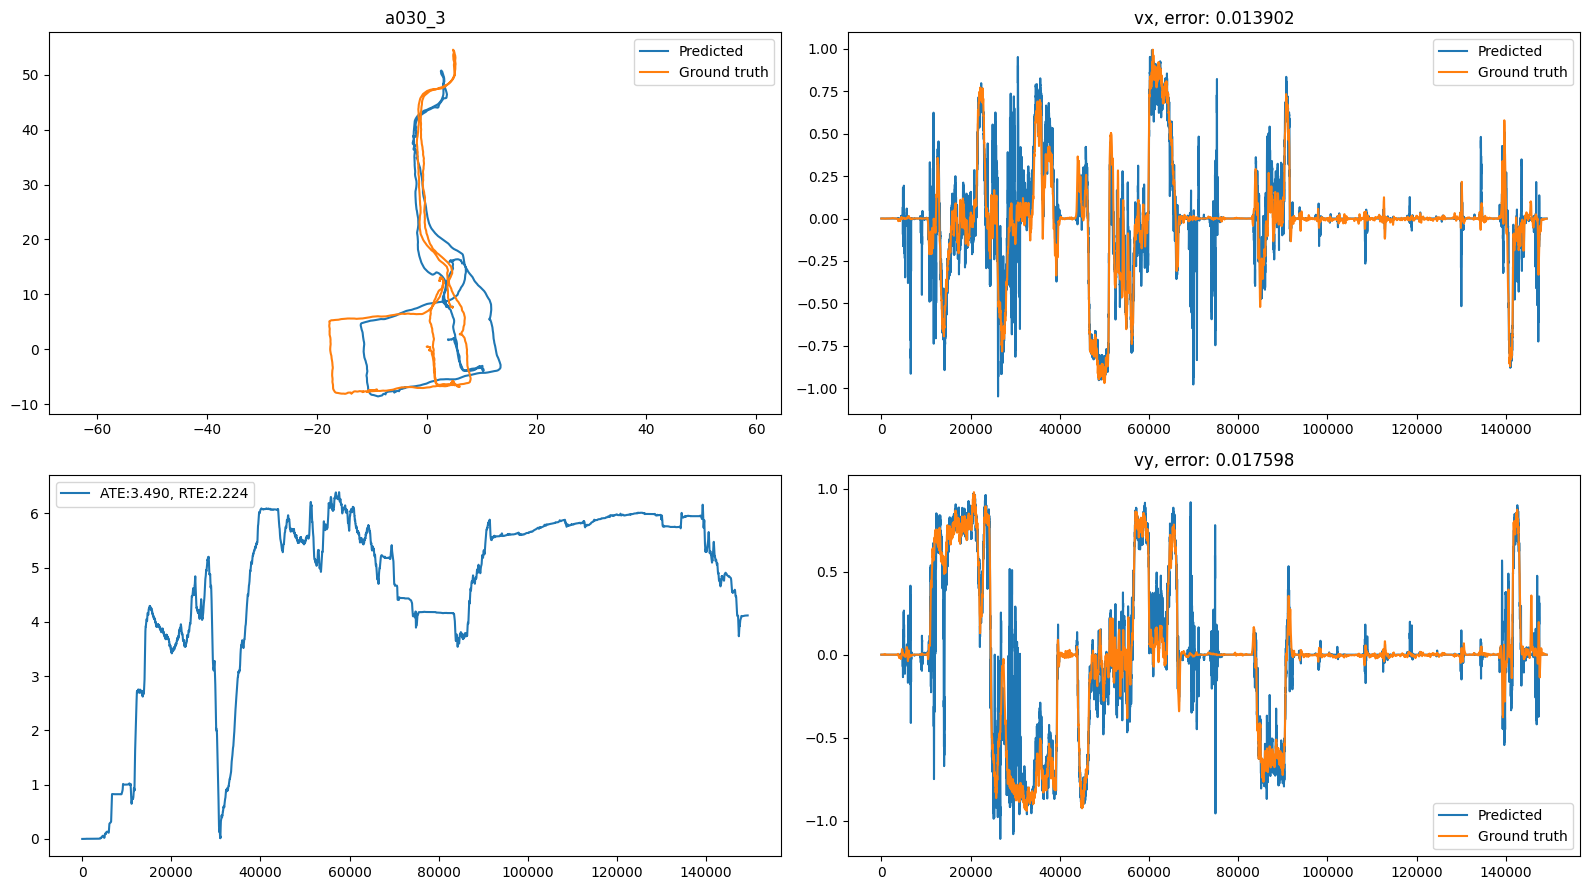

a031_2: device: samsung1, ori_error (game_rv): 4.495
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature sha

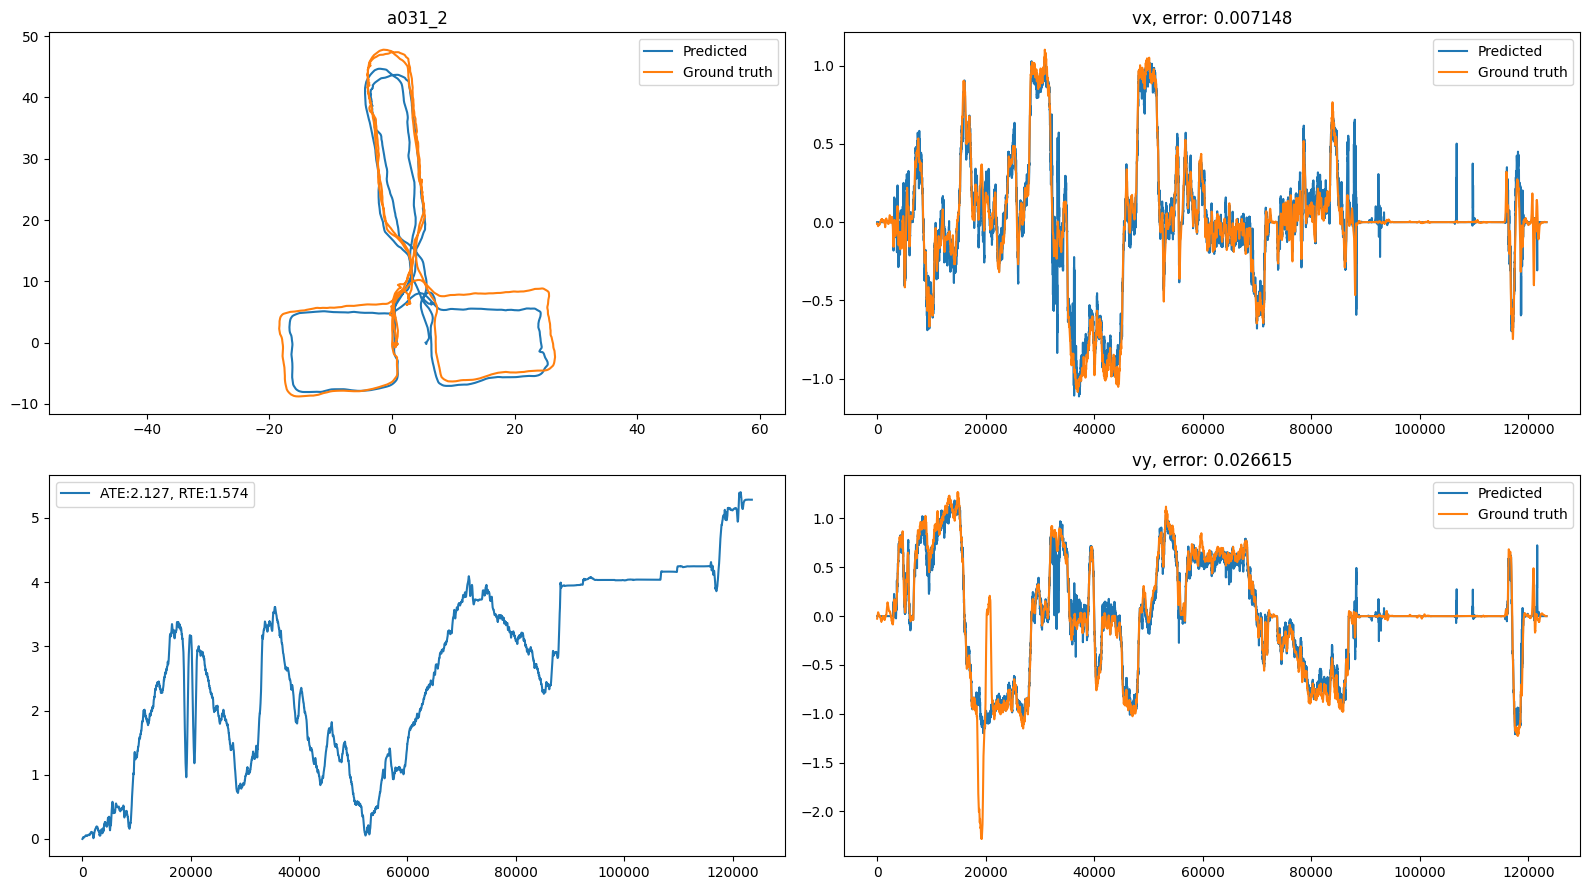

a033_2: device: samsung1, ori_error (game_rv): 1.657
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature sha

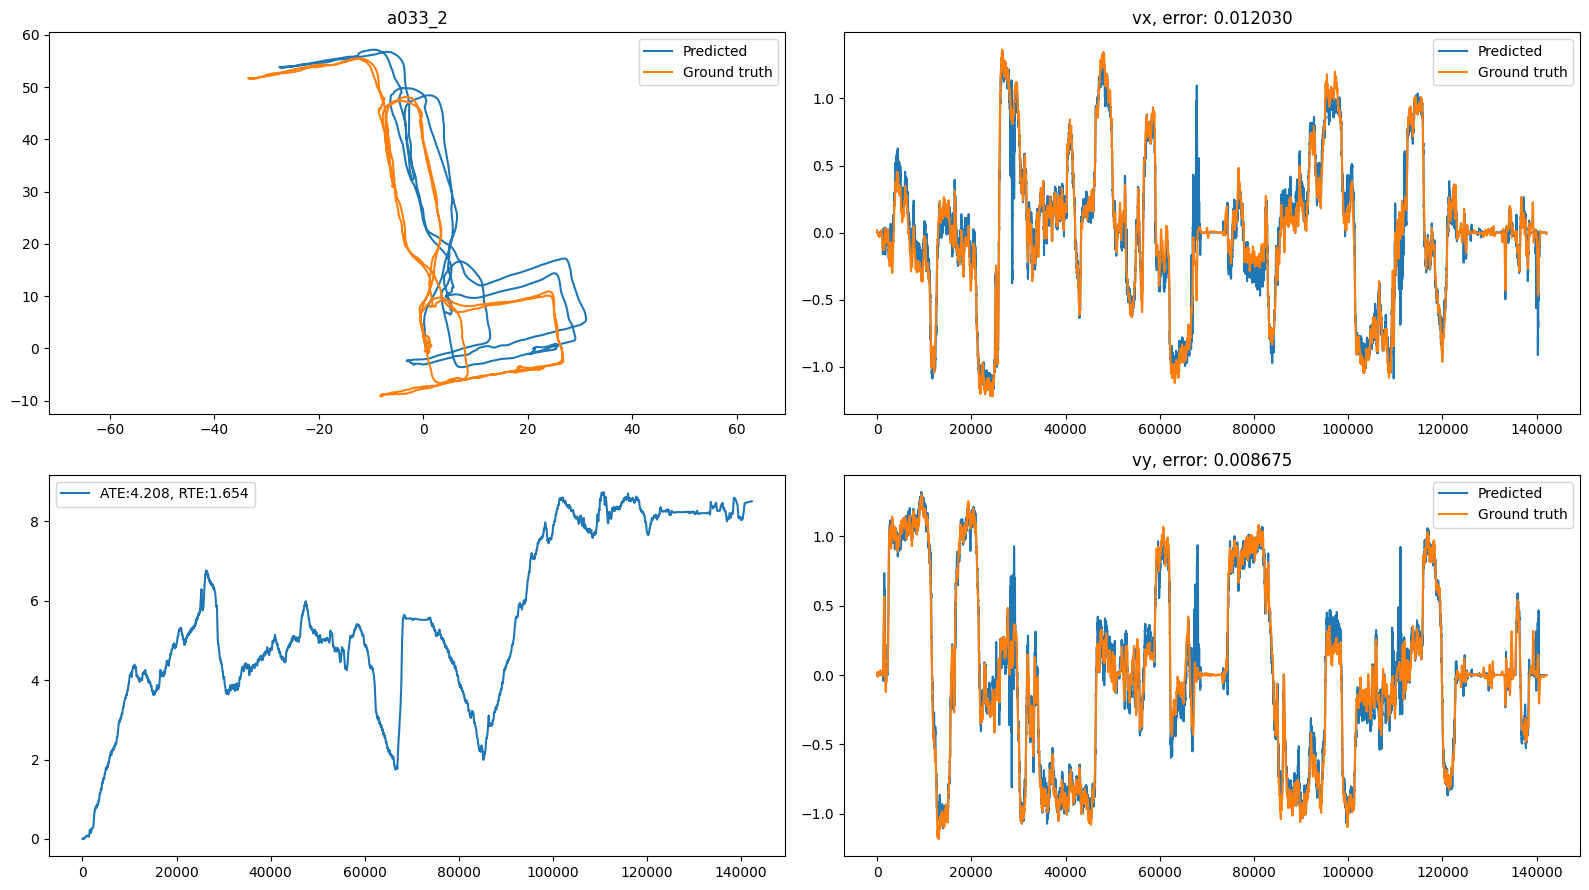

a035_3: device: samsung1, ori_error (game_rv): 8.565
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([410, 6, 200])
Target shape: torch.Size([410, 2])
targets (for 

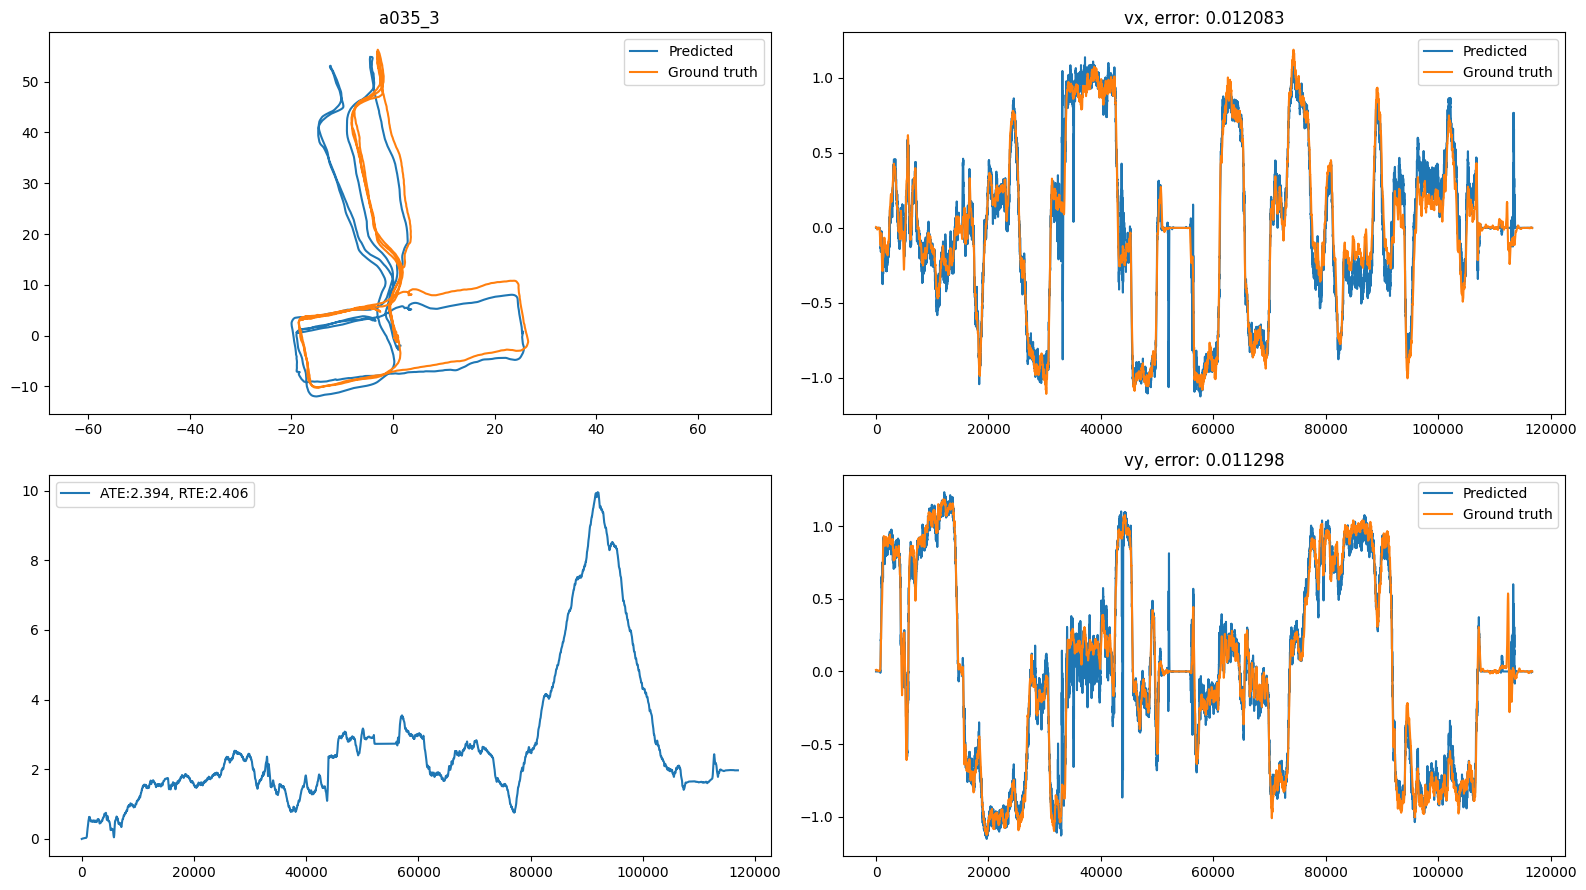

a036_2: device: asus4, ori_error (game_rv): 16.805
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape

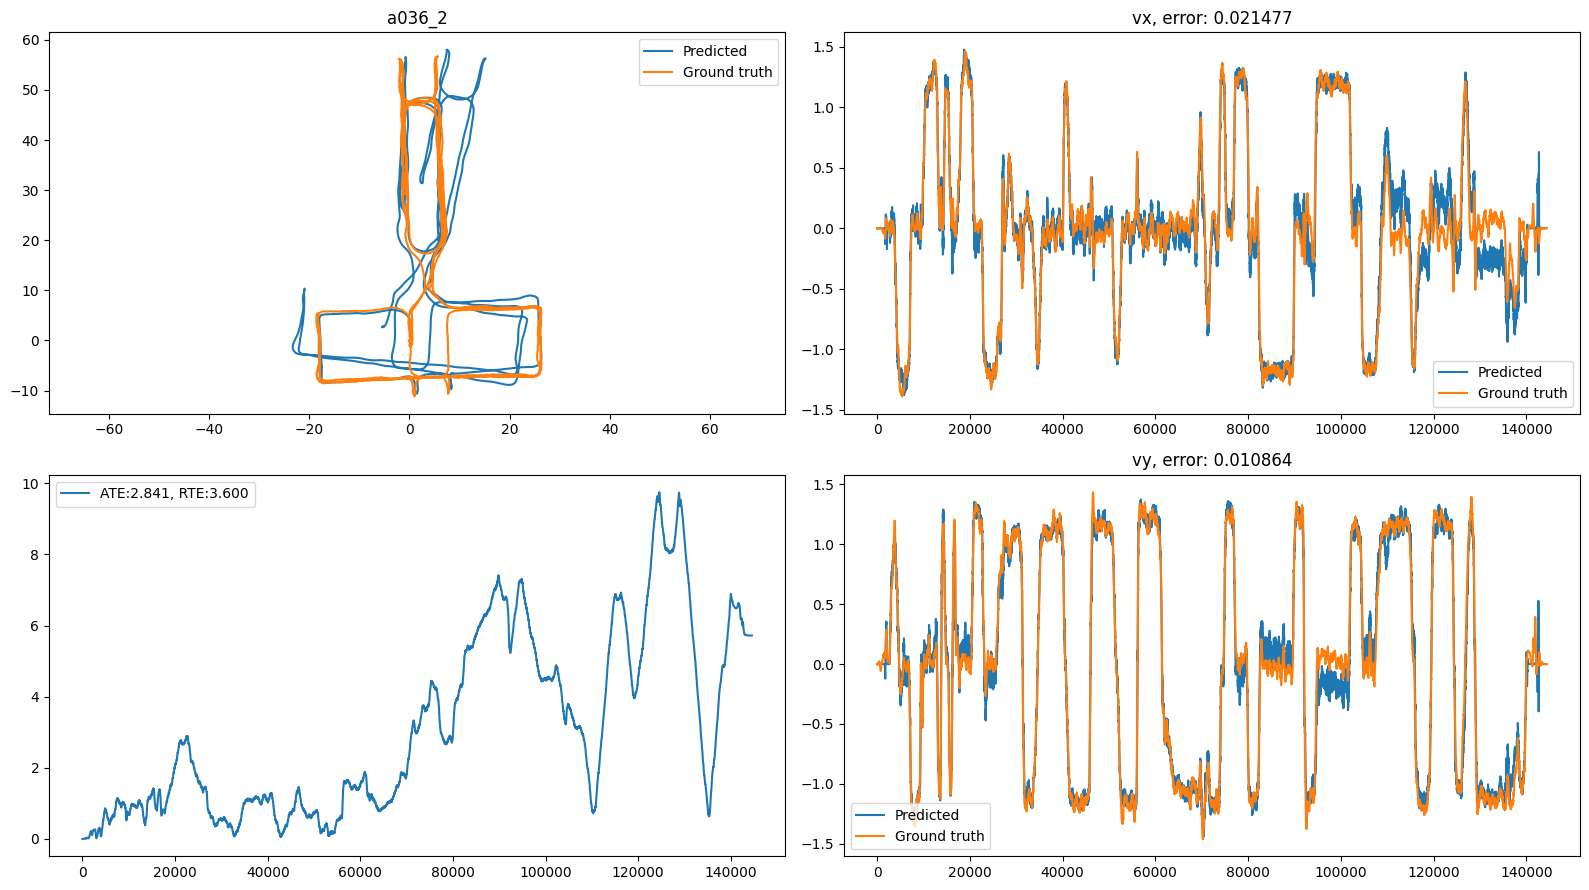

a037_1: device: asus4, ori_error (game_rv): 4.859
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([663, 6, 200])
Target shape: torch.Size([663, 2])
targets (for prediction):  [[-0.002669 0.009876]
 [-0.003300 0.009541]
 [-0.003826 0.009491]
 ...
 [-0.005929 -0.027273]
 [-0.006071 -0.026803]
 [-0.006275 -0.026168]] shap

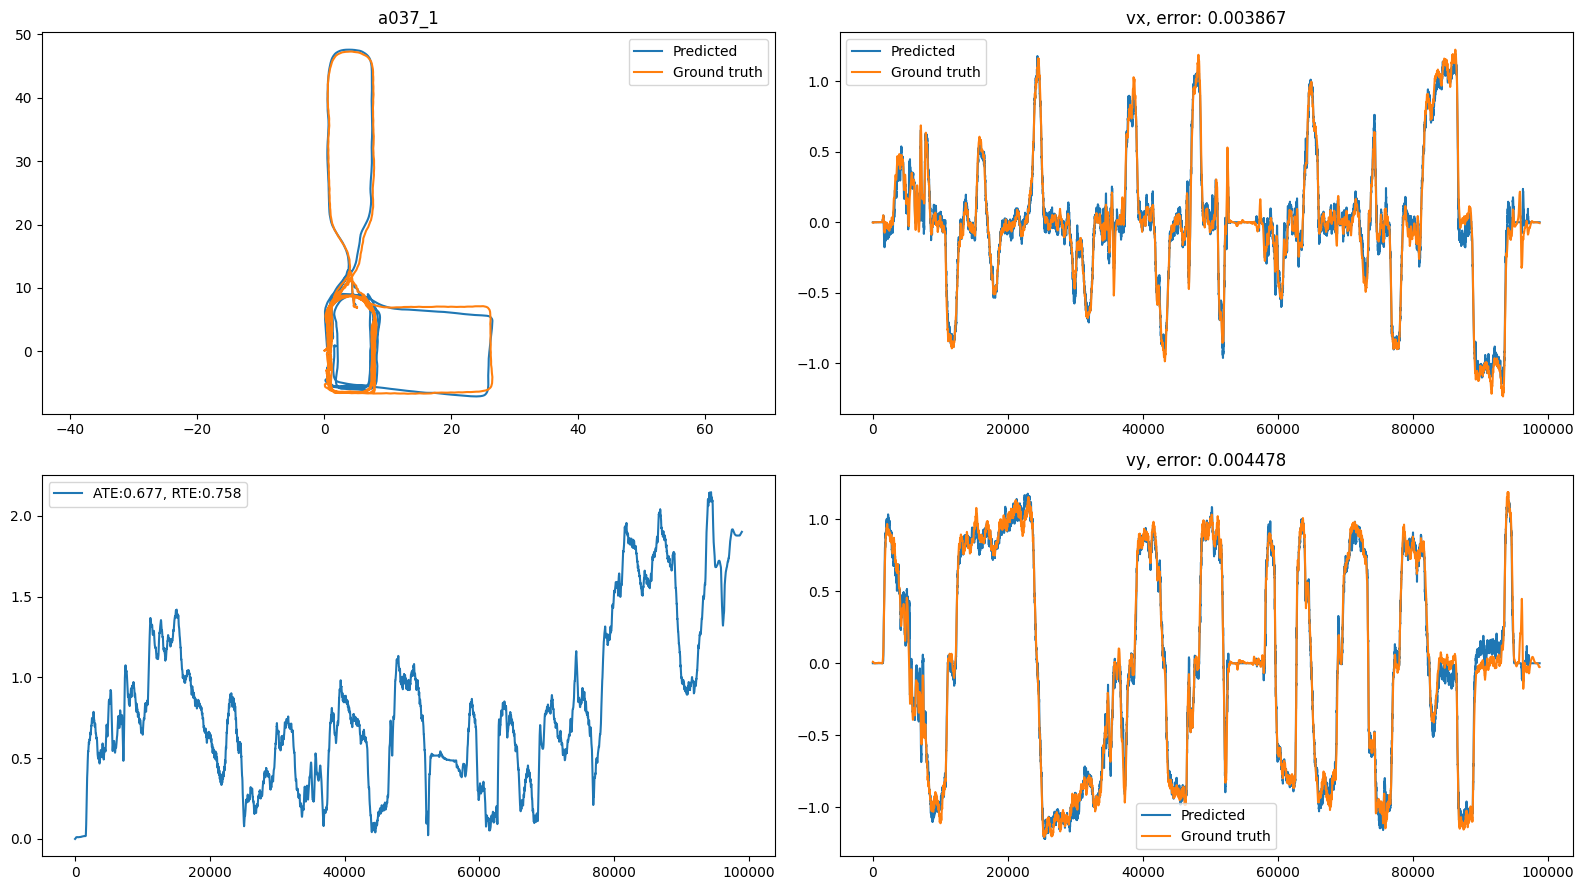

a038_2: device: samsung1, ori_error (game_rv): 5.030
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([782, 6, 200])
Target shape: torch.Size([782, 2])
targets (for prediction):  [[0.011110 -0.016203]
 [0.011780 -0.014625]
 [0.013091 -0.017344]
 ...
 [-0.006804 0.009602]
 [-0.008945 0.011226]
 [-0.010361 0.011999]] shape (8974, 2)
actual targets:  [[0.011110 -0.016203]
 [0.011032 -0.015813]
 [0.0

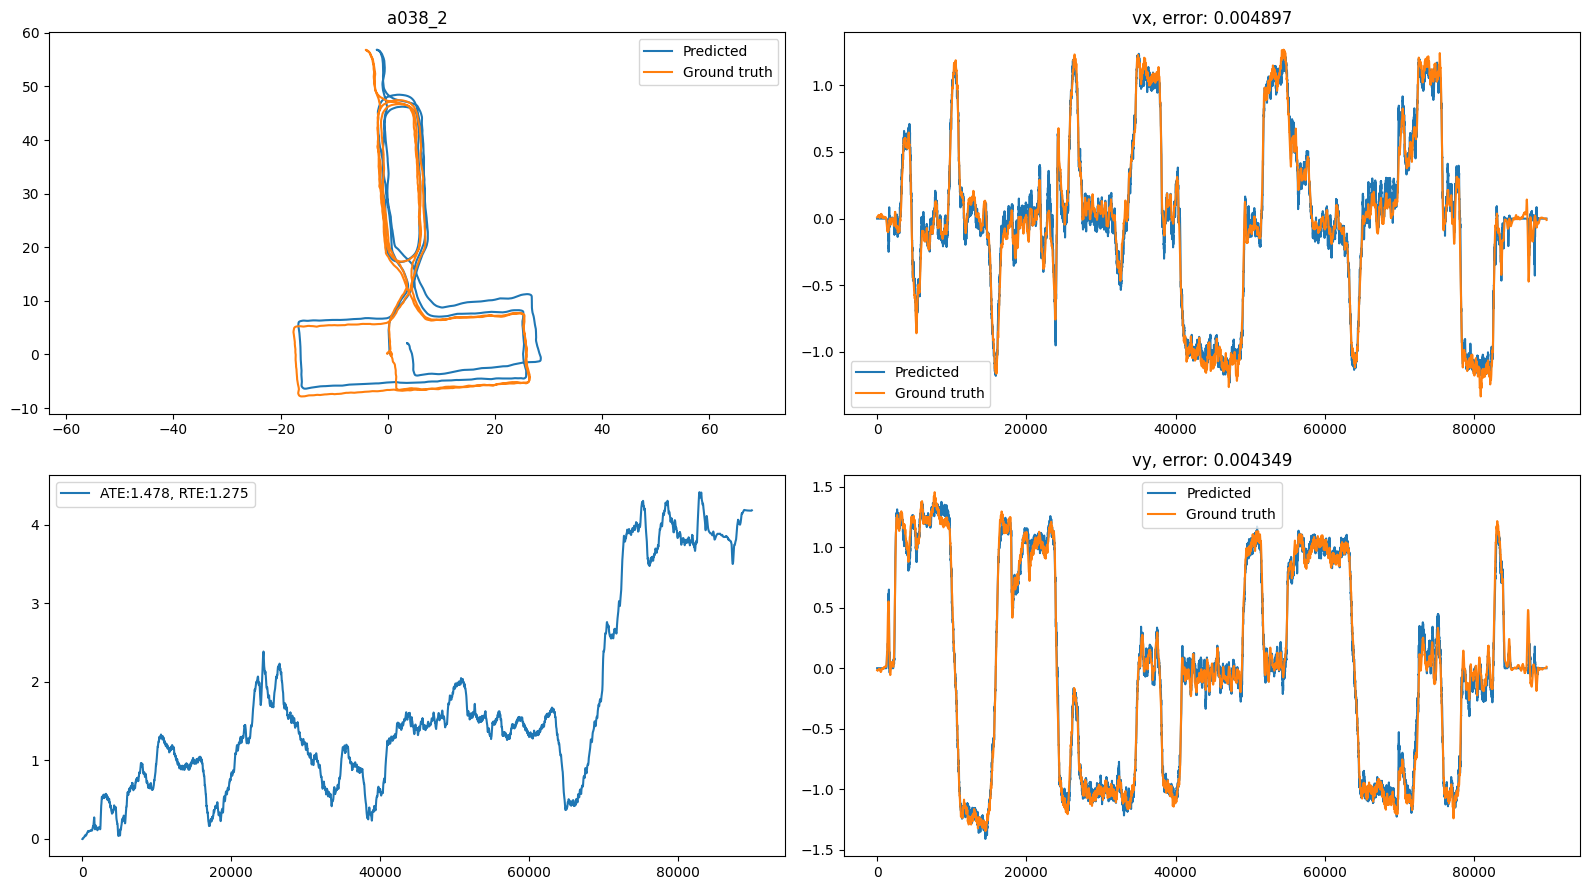

a044_2: device: samsung1, ori_error (game_rv): 2.577
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature sha

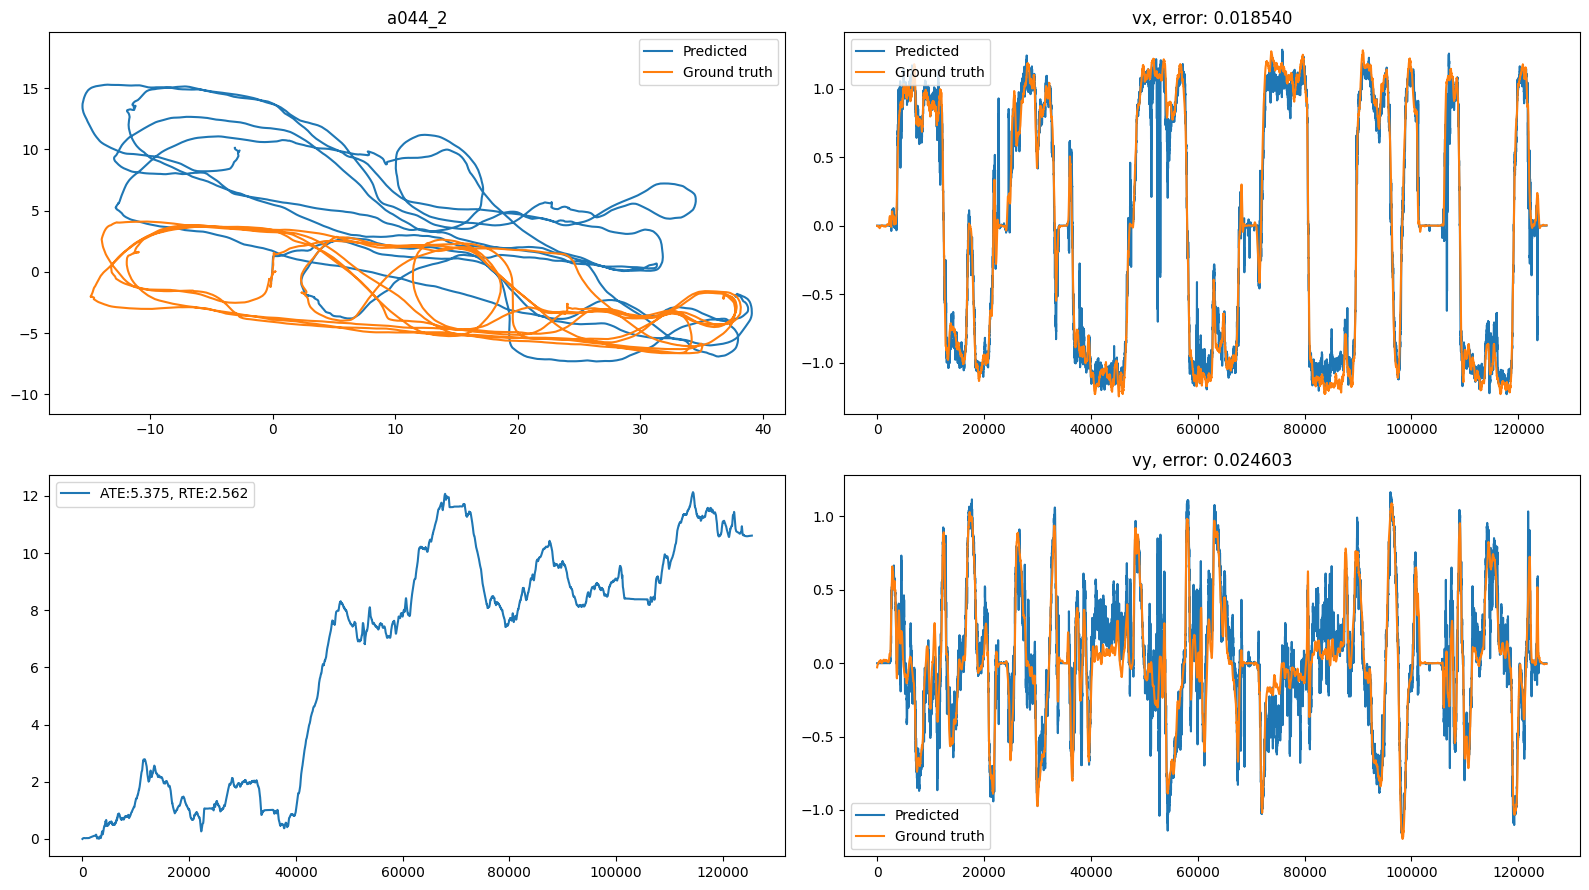

a046_2: device: samsung1, ori_error (game_rv): 12.161
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature sh

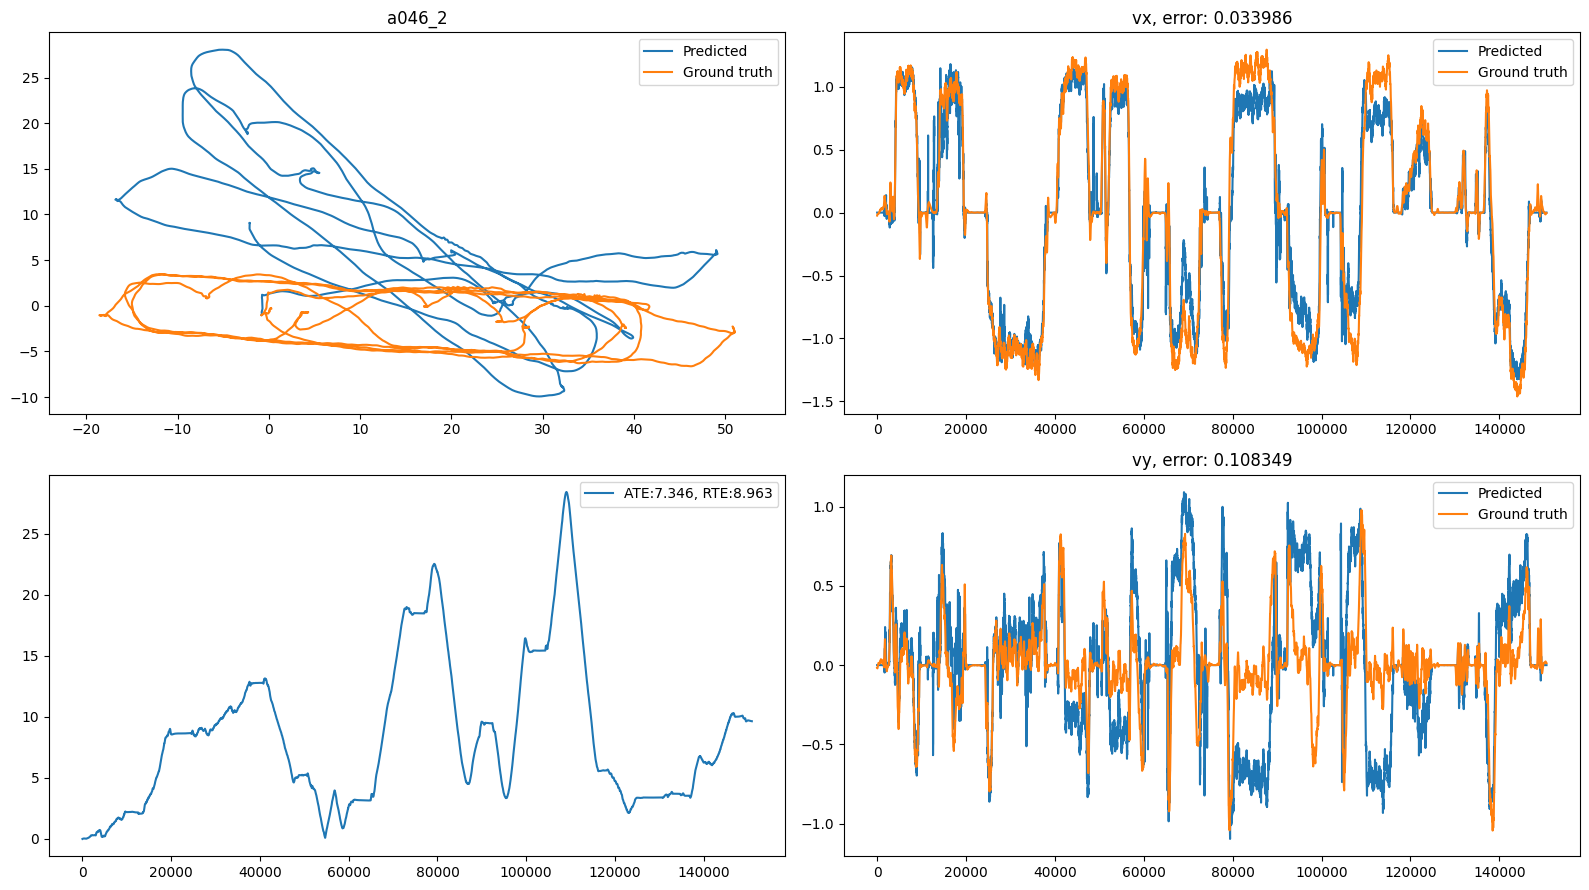

a047_2: device: asus4, ori_error (game_rv): 16.972
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape

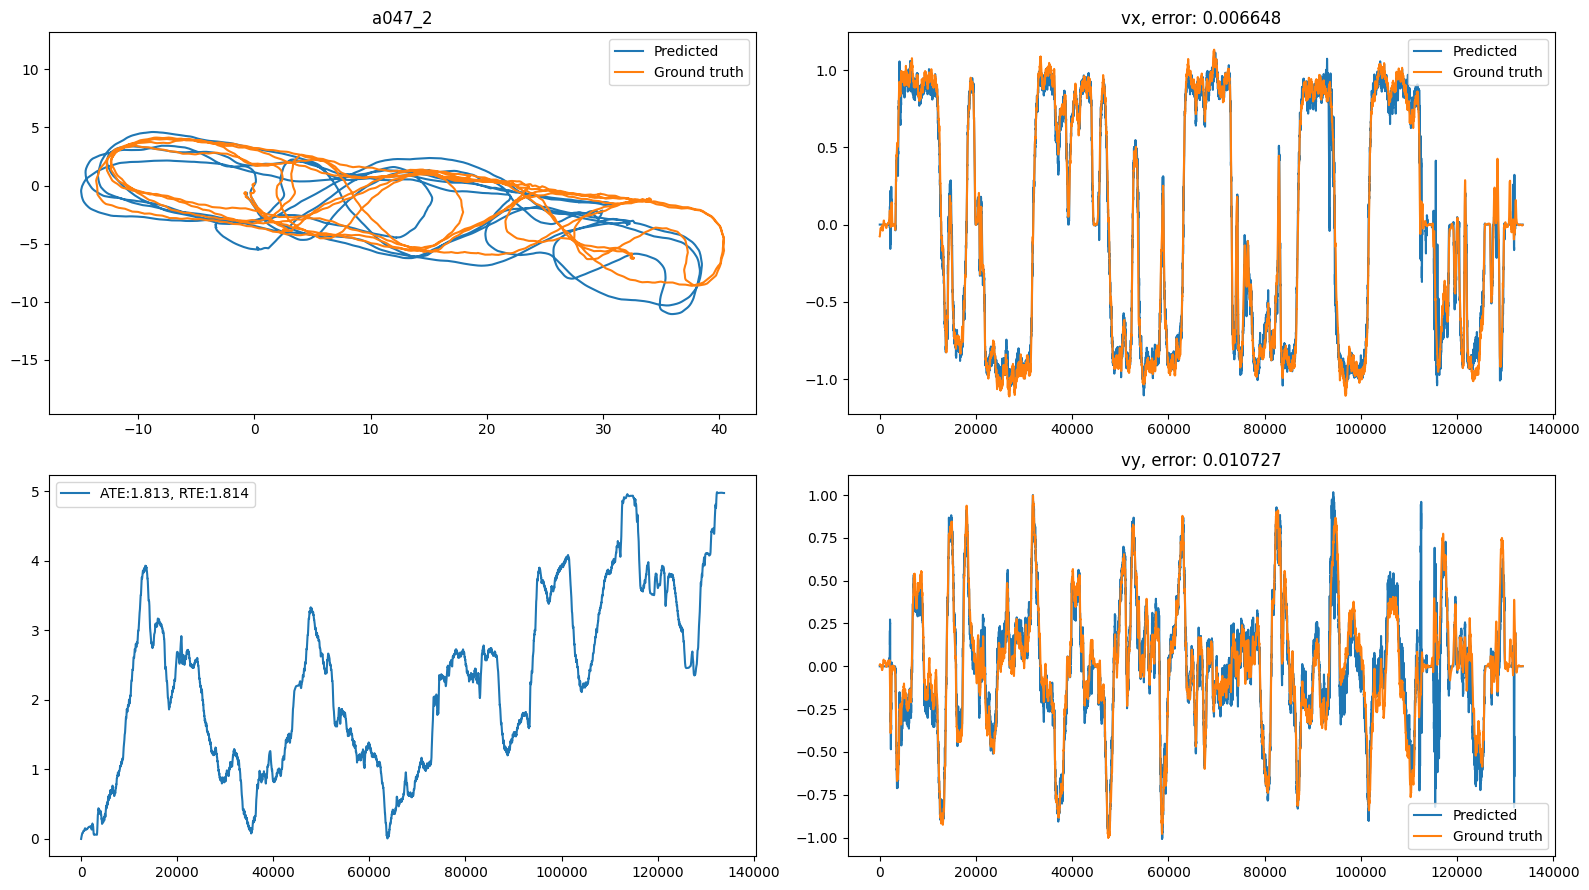

a000_7: device: asus4, ori_error (game_rv): 8.354
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([746, 6, 200])
Target shape: torch.Size([746, 2])
targets (for prediction):  [[-0.024275 0.021178]
 [-0.022833 0.024119]
 [-0.022033 0.026108]
 ...
 [-0.002311 0.006941]
 [-0.002291 0.006784]
 [-0.002315 0.006573]] shape (5866, 2)
actual targets:  [[-0.024275 0.021178]
 [-0.024065 0.021458]
 [-0.023852 0.021742]
 ...
 [-0.002334 0.006439]
 [-0.002342 0.006388]
 [-0.002349 0.006336]] shape (58656, 2)
Sequence a000_7, loss [0.010485 0.012607] / 0.011546054854989052, ate 3.240337, rte 2.836654


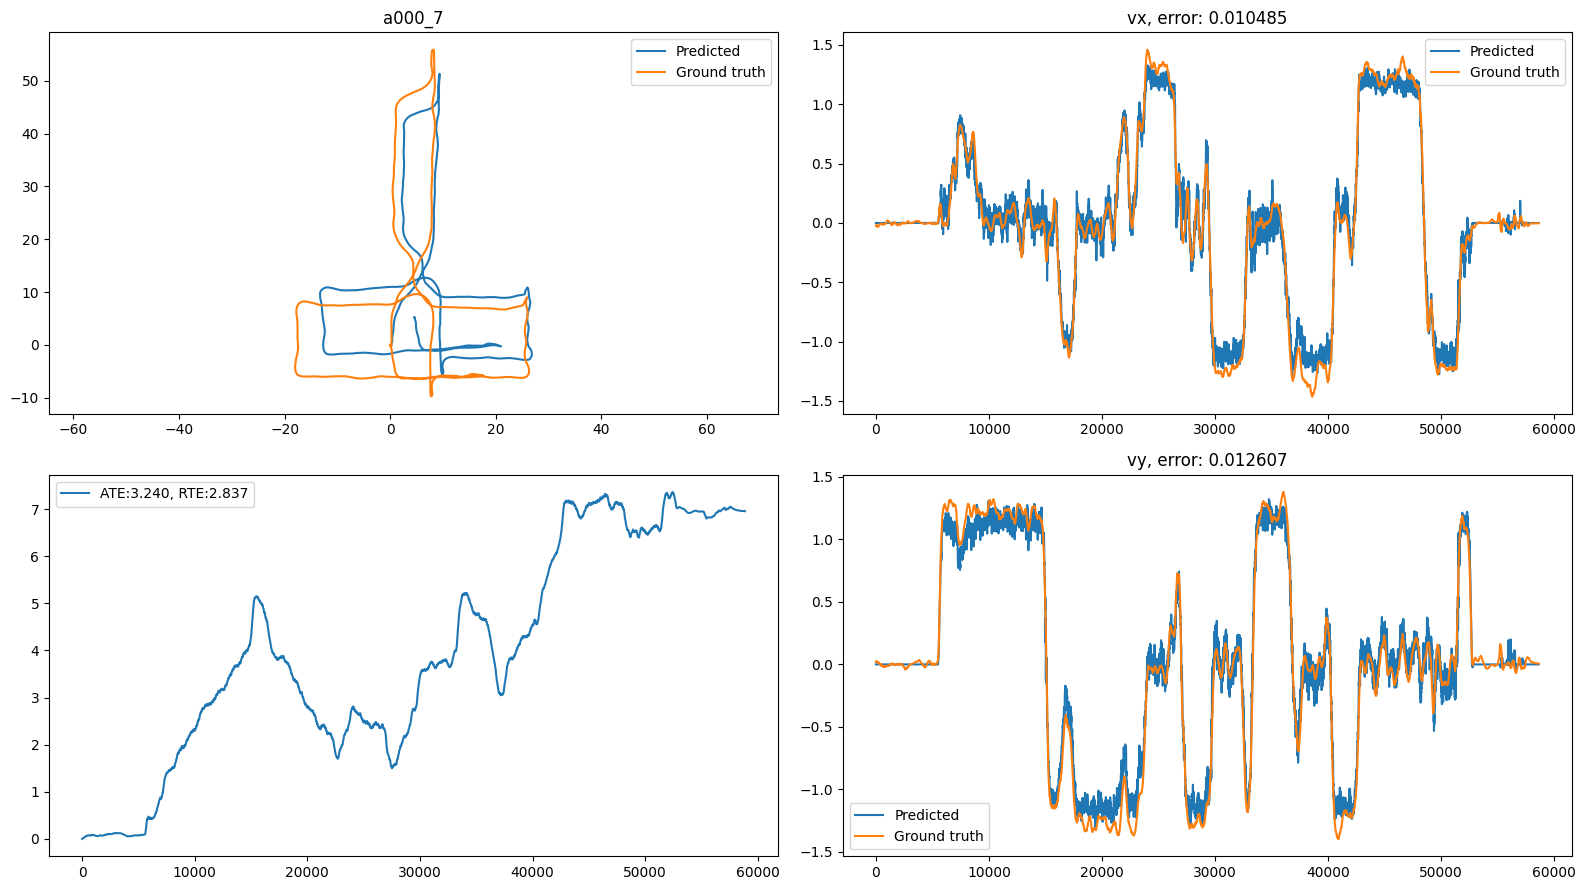

a000_11: device: asus6, ori_error (game_rv): 16.363
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([466, 6, 200])
Target shape: torch.Size([466, 2])
targets (for prediction):  [[0.000889 -0.027769]
 [-0.001451 -0.025492]
 [-0.003712 -0.024770]
 ...
 [-0.003673 0.010090]
 [-0.004674 0.010758]
 [-0.005908 0.011387]] shape (5586, 2)
actual targets:  [[0.000889 -0.027769]
 [0.000656 -0.027472]
 [0.000436 -0.027188]
 ...
 [-0.006979 0.011880]
 [-0.007150 0.011943]
 [-0.007328 0.012003]] shape (55860, 2)
Sequence a000_11, loss [0.020699 0.012826] / 0.01676272600889206, ate 5.674542, rte 5.148418


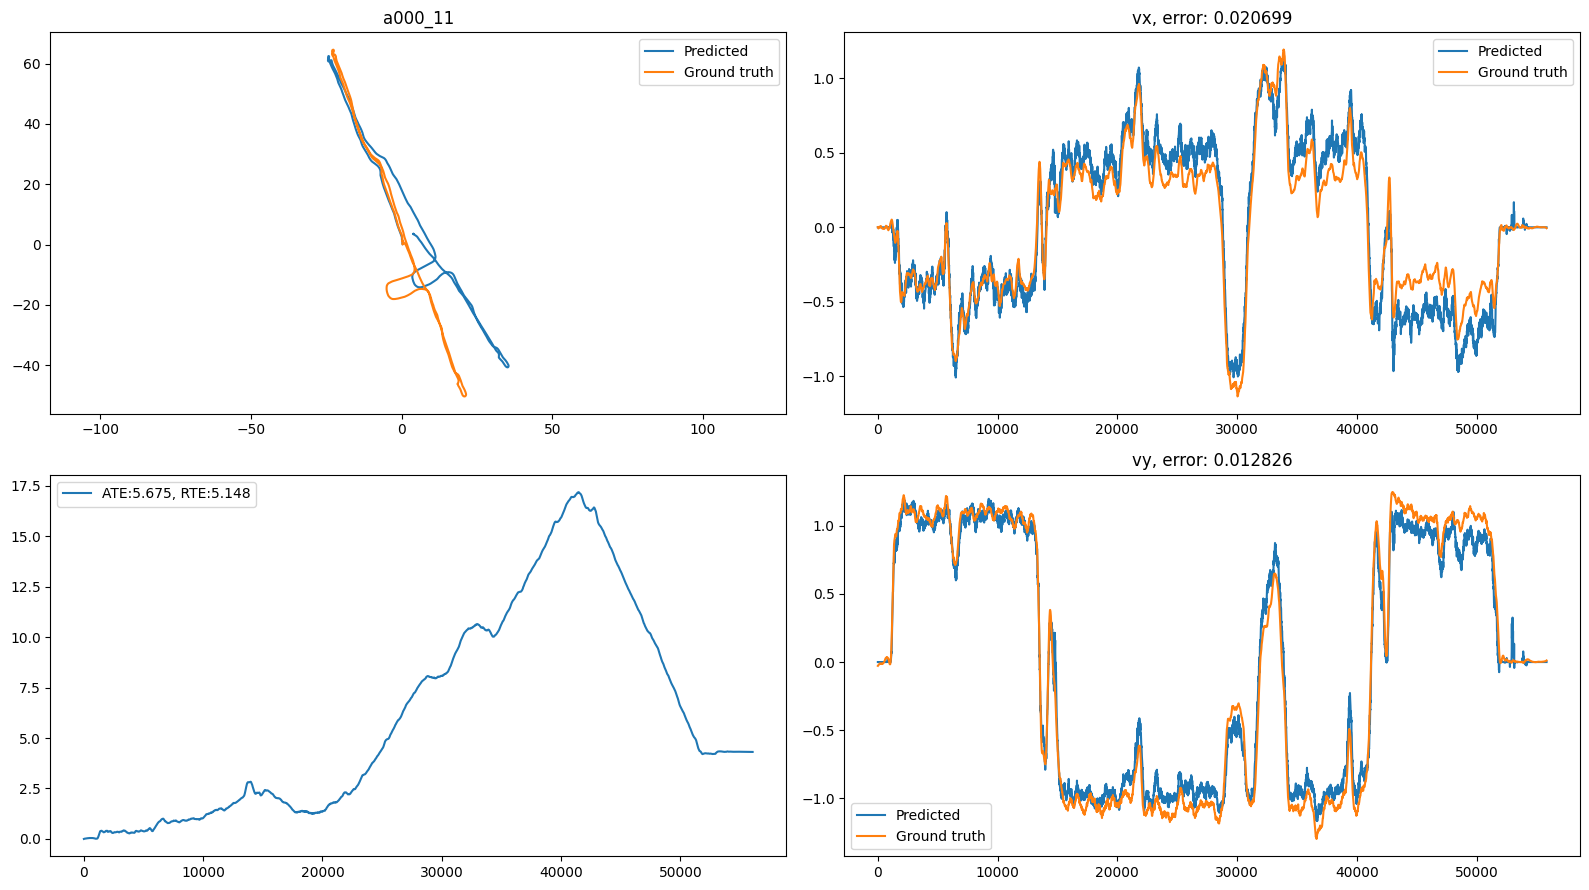

a059_2: device: asus4, ori_error (game_rv): 7.410
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([1024, 6, 200])
Target shape: torch.Size([1024, 2])
Feature shape: torch.Size([383, 6, 200])
Target shape: torch.Size([383, 2])
targets (for prediction):  [[-0.000389 0.000388]
 [-0.001114 0.000371]
 [-0.001090 0.000328]
 ...
 [-0.000165 -0.000056]
 [-0.000117 -0.000002]
 [-0.000089 0.000020]] shape (8575, 2)
actual targets:  [[-0.000389 0.000388]
 [-0.000508 0.000408]
 [-0.0

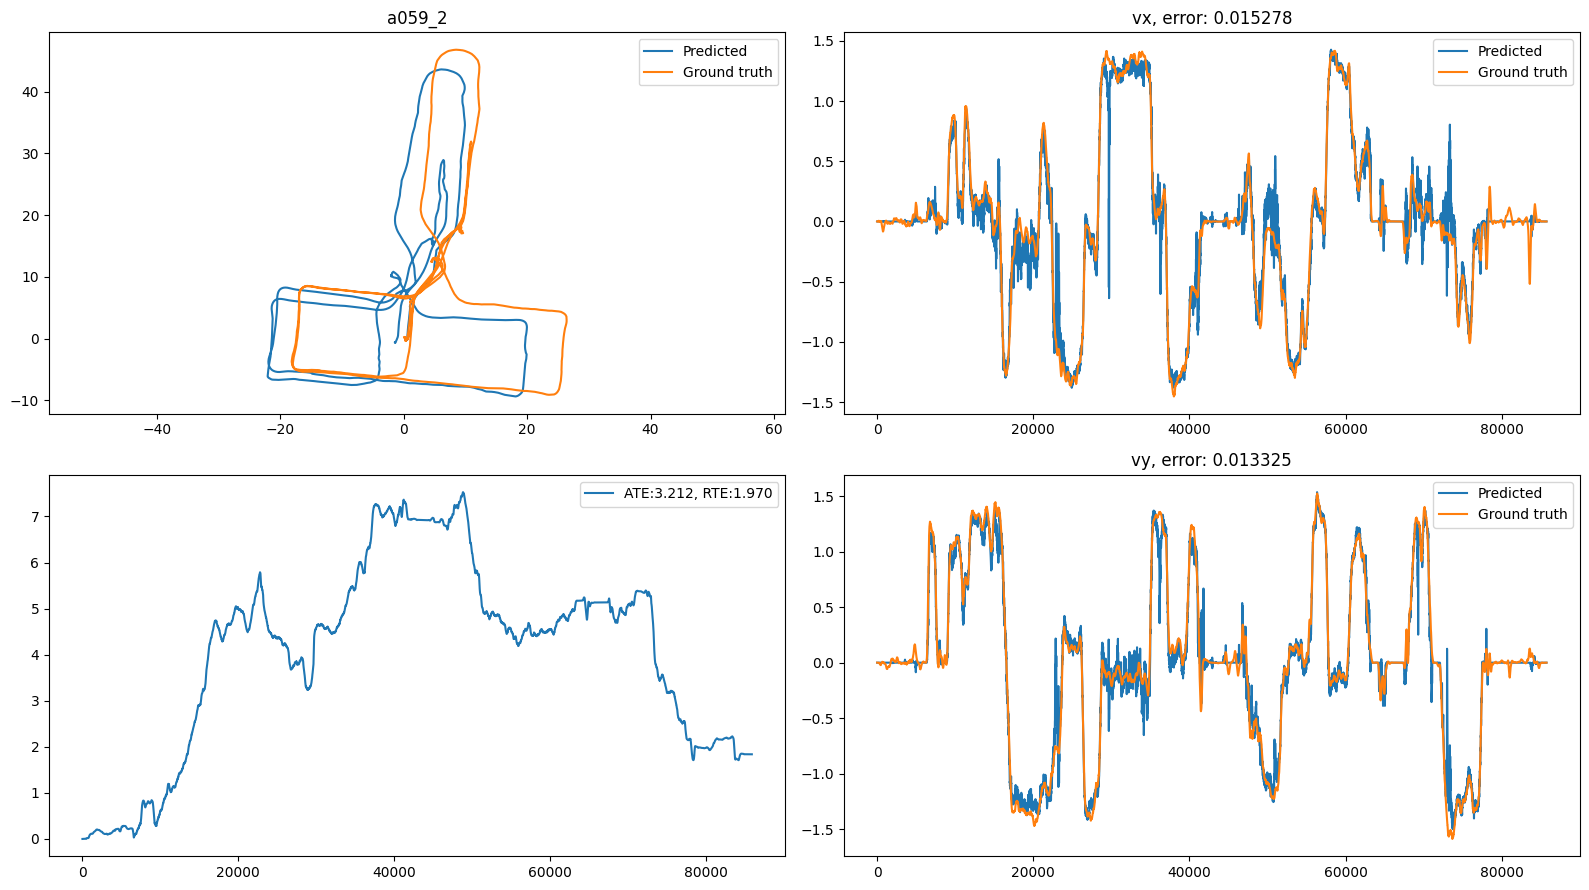

----------
Overall loss: [0.019444 0.020906]/0.02017512172460556, avg ATE:3.711395373718766, avg RTE:2.7614471195915624


array([0.011630, 0.028361, 0.012786, 0.032147, 0.038453, 0.010723,
       0.016430, 0.029017, 0.012582, 0.023333, 0.015167, 0.019198,
       0.024622, 0.016826, 0.039744, 0.009960, 0.055782, 0.012117,
       0.013049, 0.015750, 0.016882, 0.010353, 0.011691, 0.016170,
       0.004172, 0.004623, 0.021571, 0.071167, 0.008688, 0.011546,
       0.016763, 0.014302], dtype=float32)

In [50]:
test_sequence(args)